# Notebook 02: Exploratory Data Analysis

**Purpose:** Comprehensive exploratory analysis of Philadelphia crime incidents (2006-2026)

**Objectives:**
- Document univariate distributions for all key variables
- Analyze missing value patterns and their implications
- Identify initial variable relationships and correlations
- Generate testable hypotheses for downstream analysis
- Produce publication-quality visualizations and summary statistics

**Data Source:** `data/processed/crime_incidents_cleaned.parquet` (Phase 1 output)

**Methodology:** Follows 02-RESEARCH.md Pattern 5 for publication-quality figures

## 1. Environment Setup and Configuration

In [1]:
# Standard data manipulation libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import rcParams
import seaborn as sns

# Statistical libraries
from scipy import stats
from scipy.stats import chi2_contingency

# Configuration
import sys
sys.path.insert(0, '../scripts')
import config

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [2]:
# Configure matplotlib for publication-quality figures (Pattern 5 from 02-RESEARCH.md)
rcParams.update({
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'font.size': 10,
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'figure.figsize': (12, 8),
})

# Use colorblind-friendly palettes
sns.set_palette('viridis')

# Set up output directories
OUTPUT_FIGURES_DIR = config.FIGURES_DIR / 'exploratory'
OUTPUT_TABLES_DIR = config.TABLES_DIR / 'exploratory'
OUTPUT_FIGURES_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_TABLES_DIR.mkdir(parents=True, exist_ok=True)

print(f"✓ Output directories configured:")
print(f"  Figures: {OUTPUT_FIGURES_DIR}")
print(f"  Tables: {OUTPUT_TABLES_DIR}")

✓ Output directories configured:
  Figures: /Users/dustinober/Projects/Crime Incidents Philadelphia/output/figures/exploratory
  Tables: /Users/dustinober/Projects/Crime Incidents Philadelphia/output/tables/exploratory


## 2. Data Loading and Initial Inspection

In [3]:
# Load the cleaned dataset from Phase 1
df = pd.read_parquet(config.PROCESSED_DATA_DIR / 'crime_incidents_cleaned.parquet')

# Document basic data characteristics
print("=== Dataset Overview ===")
print(f"Total records: {len(df):,}")
print(f"Total columns: {len(df.columns)}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
print(f"\nDate range: {df[config.COL_DATE].min()} to {df[config.COL_DATE].max()}")
print(f"Years covered: {df['year'].min()} - {df['year'].max()}")

print("\n=== Column Summary ===")
for col in df.columns:
    dtype = df[col].dtype
    non_null = df[col].notna().sum()
    null_pct = (df[col].isna().sum() / len(df)) * 100
    print(f"{col:25s} | {str(dtype):15s} | {non_null:>10,} | {null_pct:>5.1f}% null")

=== Dataset Overview ===
Total records: 3,485,365
Total columns: 17
Memory usage: 534.4 MB

Date range: 2006-01-01 05:00:00+00:00 to 2025-12-22 04:46:00+00:00
Years covered: 2006 - 2025

=== Column Summary ===
the_geom                  | category        |  3,429,619 |   1.6% null
cartodb_id                | int64           |  3,485,365 |   0.0% null
the_geom_webmercator      | category        |  3,429,502 |   1.6% null
objectid                  | int64           |  3,485,365 |   0.0% null
dc_dist                   | int64           |  3,485,365 |   0.0% null
psa                       | str             |  3,484,069 |   0.0% null
dispatch_date_time        | datetime64[ns, UTC] |  3,485,365 |   0.0% null
dispatch_date             | category        |  3,485,365 |   0.0% null
dispatch_time             | category        |  3,485,365 |   0.0% null
hour                      | float64         |  3,383,120 |   2.9% null
dc_key                    | float64         |  3,485,365 |   0.0% null
locat

In [4]:
# Apply reporting lag exclusion (per Phase 1 decision: exclude last 30 days)
max_date = df[config.COL_DATE].max()
cutoff_date = max_date - timedelta(days=30)

print(f"Maximum date in dataset: {max_date.strftime('%Y-%m-%d')}")
print(f"Exclusion cutoff (30-day lag): {cutoff_date.strftime('%Y-%m-%d')}")

# Create analysis dataset excluding recent data
df_analysis = df[df[config.COL_DATE] <= cutoff_date].copy()
excluded_count = len(df) - len(df_analysis)

print(f"\nRecords excluded (last 30 days): {excluded_count:,}")
print(f"Records for analysis: {len(df_analysis):,}")
print(f"Analysis date range: {df_analysis[config.COL_DATE].min().strftime('%Y-%m-%d')} to {df_analysis[config.COL_DATE].max().strftime('%Y-%m-%d')}")

Maximum date in dataset: 2025-12-22
Exclusion cutoff (30-day lag): 2025-11-22



Records excluded (last 30 days): 11,355
Records for analysis: 3,474,010
Analysis date range: 2006-01-01 to 2025-11-22


In [5]:
# Create derived time features for analysis
df_analysis['month'] = df_analysis[config.COL_DATE].dt.month
df_analysis['day_of_week'] = df_analysis[config.COL_DATE].dt.dayofweek  # 0=Monday
df_analysis['day_name'] = df_analysis[config.COL_DATE].dt.day_name()
df_analysis['hour'] = df_analysis[config.COL_DATE].dt.hour

# Create offense severity classification based on UCR codes
# Note: These mappings will be refined based on actual data exploration
def classify_offense(ucr_code):
    """Classify offense by UCR general code."""
    if ucr_code in config.UCR_VIOLENT:
        return 'Violent'
    elif ucr_code in config.UCR_PROPERTY:
        return 'Property'
    else:
        return 'Other'

df_analysis['offense_category'] = df_analysis[config.COL_UCR_GENERAL].apply(classify_offense)

print("✓ Derived features created")
print(f"\nOffense category distribution:")
print(df_analysis['offense_category'].value_counts())

✓ Derived features created

Offense category distribution:
offense_category
Other       2053886
Property    1088556
Violent      331568
Name: count, dtype: int64


## 3. Missing Value Analysis

Document missing value patterns to understand data quality and potential biases.

In [6]:
# Calculate missing value statistics
missing_stats = pd.DataFrame({
    'column': df_analysis.columns,
    'missing_count': df_analysis.isna().sum(),
    'missing_pct': (df_analysis.isna().sum() / len(df_analysis)) * 100,
    'dtype': df_analysis.dtypes
}).sort_values('missing_pct', ascending=False)

print("=== Missing Value Summary ===")
print(missing_stats.to_string(index=False))

# Save missing value summary
missing_stats.to_csv(OUTPUT_TABLES_DIR / 'missing_value_summary.csv', index=False)
print(f"\n✓ Missing value summary saved to {OUTPUT_TABLES_DIR / 'missing_value_summary.csv'}")

=== Missing Value Summary ===
              column  missing_count  missing_pct               dtype
the_geom_webmercator          55697     1.603248            category
                 lat          55682     1.602816             float64
                 lng          55682     1.602816             float64
            the_geom          55580     1.599880            category
                 psa           1296     0.037306                 str
      location_block            187     0.005383                 str
         ucr_general              0     0.000000               int64
            day_name              0     0.000000                 str
         day_of_week              0     0.000000               int32
               month              0     0.000000               int32
                year              0     0.000000               int32
   text_general_code              0     0.000000                 str
              dc_key              0     0.000000             float64
    

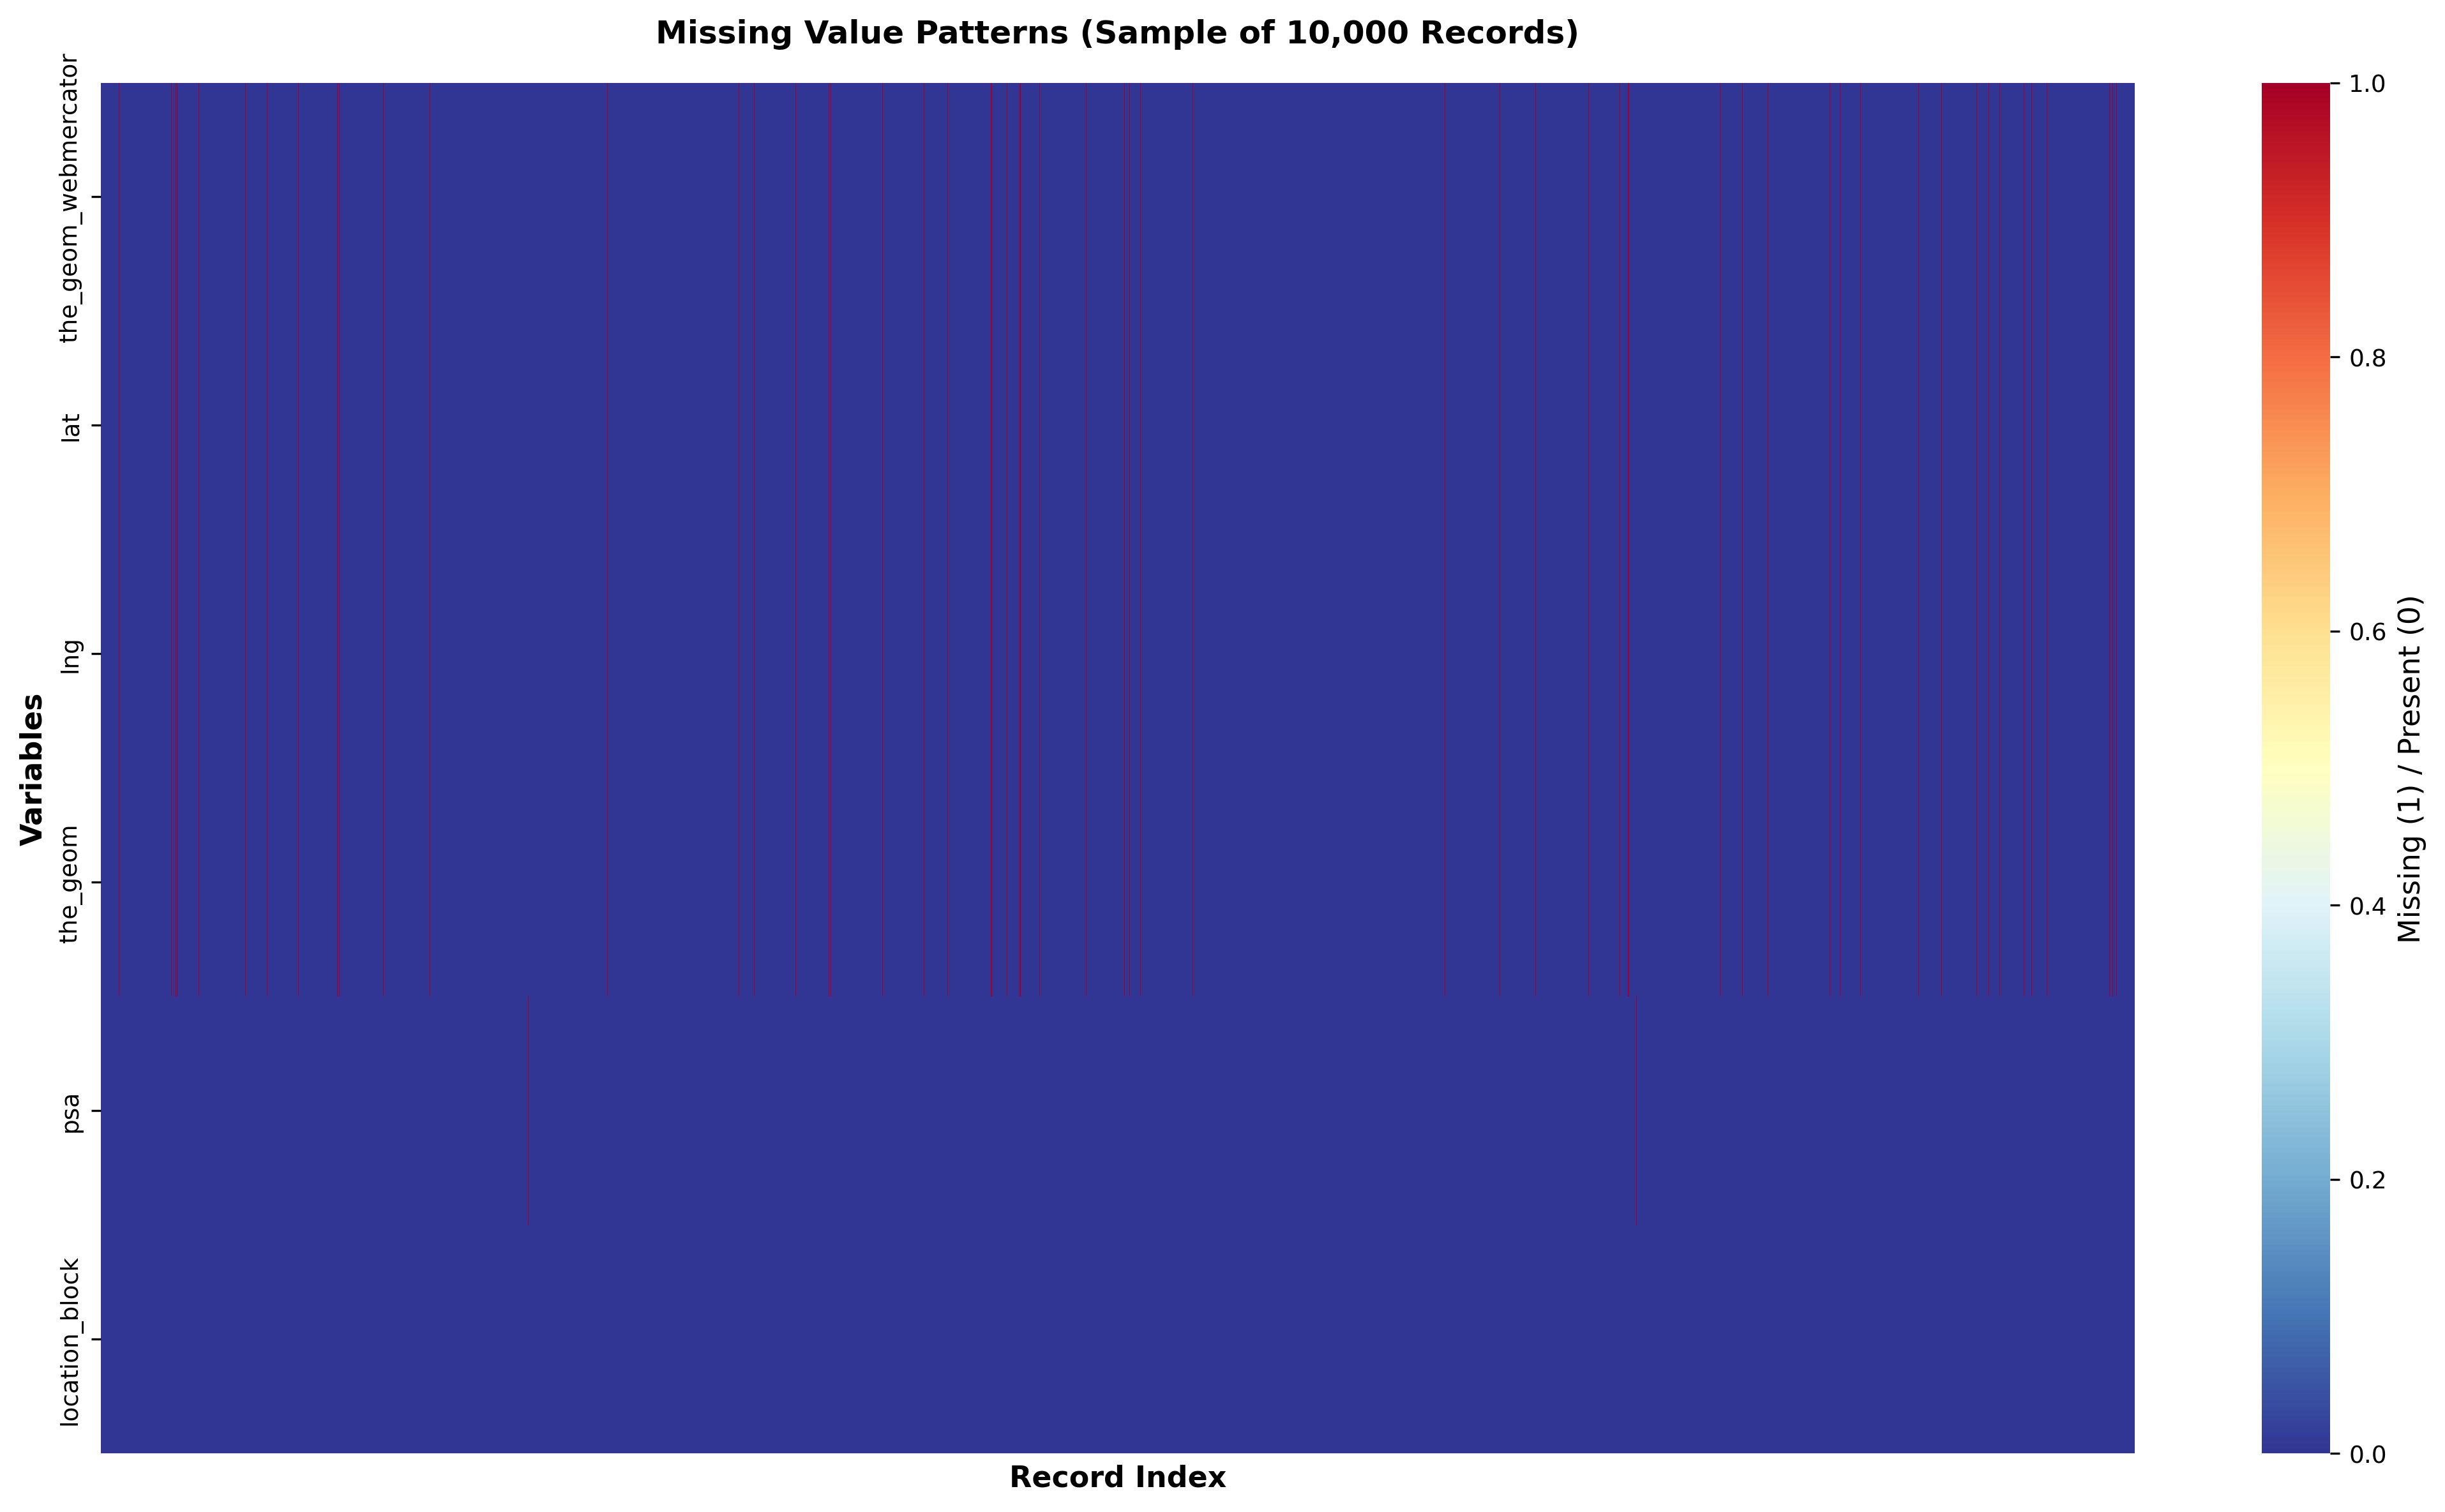


✓ Missing value heatmap saved


In [7]:
# Create missing value heatmap
fig, ax = plt.subplots(figsize=(14, 8))

# Select columns with missing values for visualization
cols_with_missing = missing_stats[missing_stats['missing_pct'] > 0]['column'].tolist()

if cols_with_missing:
    # Sample data for visualization (heatmap on full dataset is too large)
    sample_size = min(10000, len(df_analysis))
    df_sample = df_analysis.sample(n=sample_size, random_state=42)
    
    # Create binary missing indicator matrix
    missing_matrix = df_sample[cols_with_missing].isna().astype(int)
    
    # Plot heatmap
    sns.heatmap(missing_matrix.T, 
                cmap='RdYlBu_r',
                cbar_kws={'label': 'Missing (1) / Present (0)'},
                xticklabels=False,
                ax=ax)
    
    ax.set_title('Missing Value Patterns (Sample of 10,000 Records)', fontweight='bold', pad=15)
    ax.set_xlabel('Record Index', fontweight='bold')
    ax.set_ylabel('Variables', fontweight='bold')
    
    plt.tight_layout()
    fig.savefig(OUTPUT_FIGURES_DIR / 'missing_values_heatmap.png', 
                dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print(f"\n✓ Missing value heatmap saved")
else:
    print("No missing values detected in dataset.")

In [8]:
# Analyze missing value co-occurrence patterns
print("=== Missing Value Co-occurrence Analysis ===\n")

# Check if missing coordinates correlate with other missing values
if df_analysis[config.COL_LAT].isna().any():
    missing_coords = df_analysis[config.COL_LAT].isna()
    print(f"Records with missing coordinates: {missing_coords.sum():,} ({missing_coords.mean()*100:.2f}%)")
    
    # Check if missing coords correlate with specific offense types
    missing_by_offense = df_analysis[missing_coords]['text_general_code'].value_counts().head(10)
    print("\nTop offense types with missing coordinates:")
    print(missing_by_offense)
    
    # Check temporal pattern of missing coords
    missing_by_year = df_analysis[missing_coords].groupby('year').size()
    total_by_year = df_analysis.groupby('year').size()
    missing_rate_by_year = (missing_by_year / total_by_year * 100).fillna(0)
    
    print("\nMissing coordinate rate by year:")
    for year, rate in missing_rate_by_year.items():
        print(f"  {year}: {rate:.2f}%")

# Check other missing patterns
for col in ['psa', 'hour', 'dc_key']:
    if df_analysis[col].isna().any():
        missing_count = df_analysis[col].isna().sum()
        missing_pct = missing_count / len(df_analysis) * 100
        print(f"\n{col}: {missing_count:,} missing ({missing_pct:.2f}%)")

=== Missing Value Co-occurrence Analysis ===

Records with missing coordinates: 55,682 (1.60%)

Top offense types with missing coordinates:
text_general_code
Thefts                            11674
Other Assaults                     6802
All Other Offenses                 6140
Theft from Vehicle                 5448
Vandalism/Criminal Mischief        3769
Motor Vehicle Theft                3206
Fraud                              2843
DRIVING UNDER THE INFLUENCE        2315
Narcotic / Drug Law Violations     2155
Aggravated Assault No Firearm      1852
Name: count, dtype: int64

Missing coordinate rate by year:
  2006: 2.49%
  2007: 2.03%
  2008: 1.64%
  2009: 1.68%
  2010: 1.64%
  2011: 1.47%
  2012: 1.34%
  2013: 1.41%
  2014: 1.25%
  2015: 1.18%
  2016: 1.08%
  2017: 1.08%
  2018: 1.25%
  2019: 0.05%
  2020: 0.01%
  2021: 0.04%
  2022: 0.59%
  2023: 4.13%
  2024: 4.20%
  2025: 2.58%

psa: 1,296 missing (0.04%)


## 4. Univariate Distributions: Temporal Variables

Analyze the distribution of incidents across time dimensions.

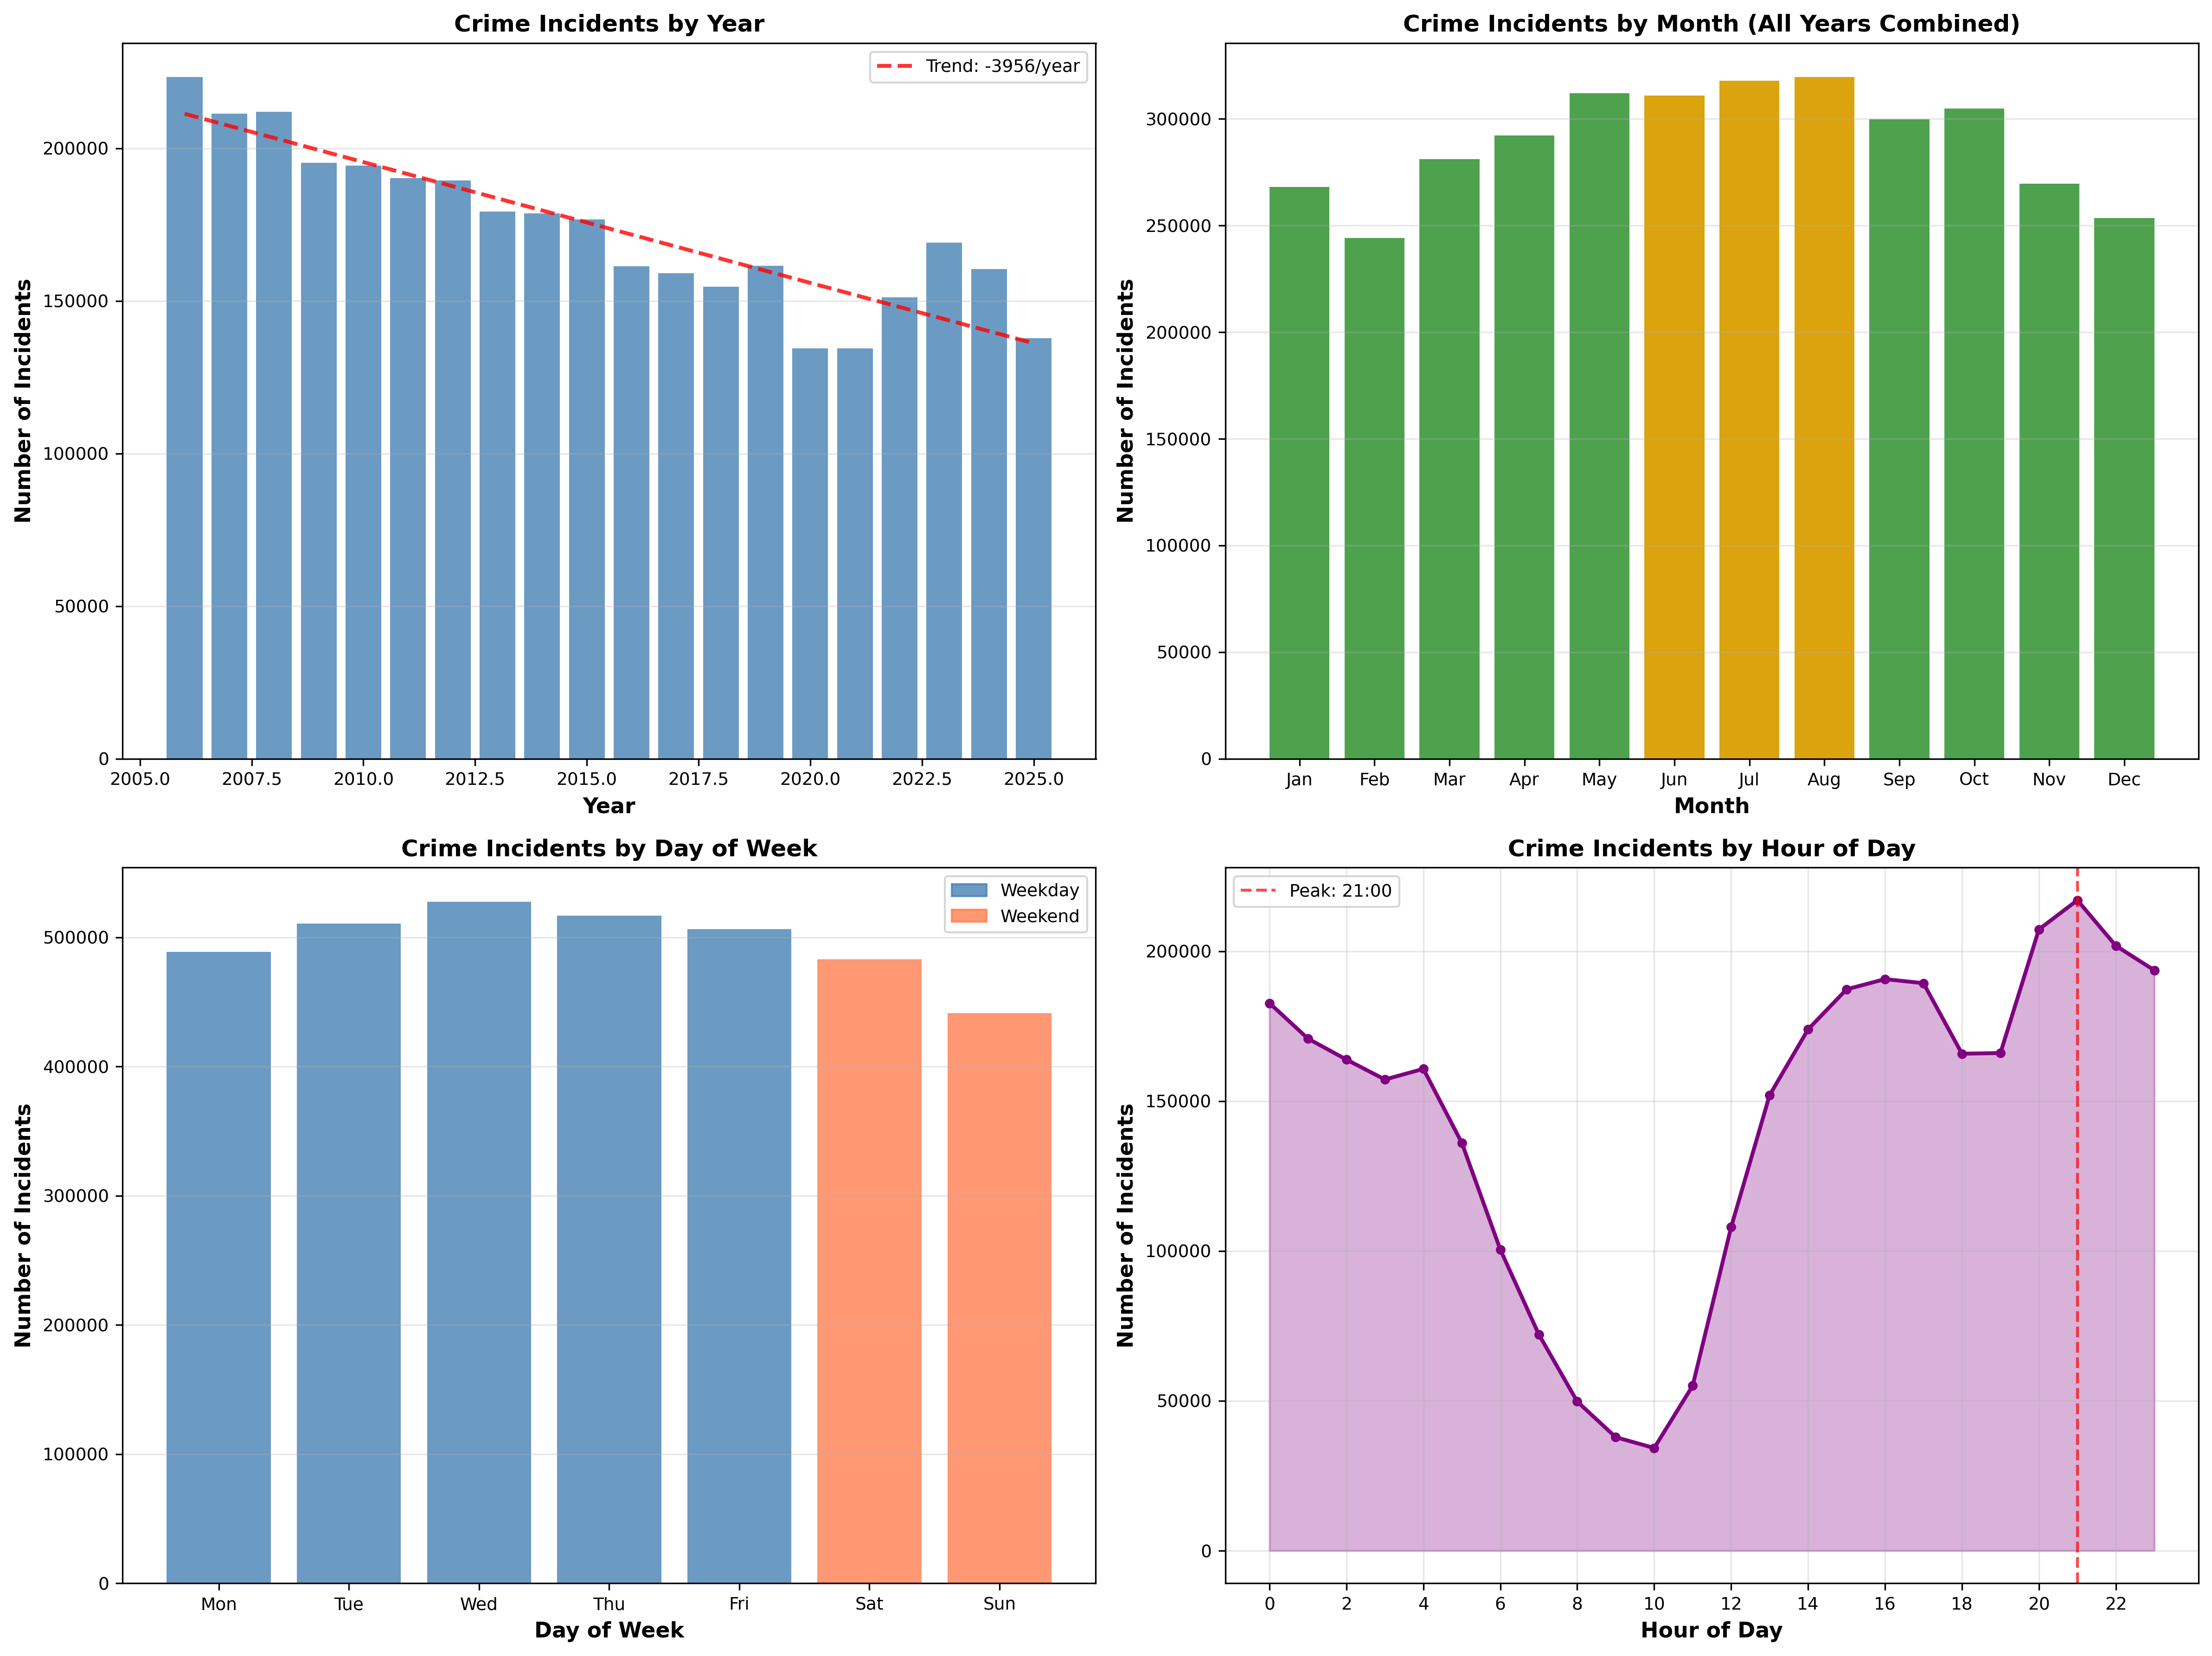

✓ Temporal distributions figure saved


In [9]:
# Create temporal distribution analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribution by Year
yearly_counts = df_analysis.groupby('year').size()
axes[0, 0].bar(yearly_counts.index, yearly_counts.values, color='steelblue', alpha=0.8)
axes[0, 0].set_xlabel('Year', fontweight='bold')
axes[0, 0].set_ylabel('Number of Incidents', fontweight='bold')
axes[0, 0].set_title('Crime Incidents by Year', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Add trend line
z = np.polyfit(yearly_counts.index, yearly_counts.values, 1)
p = np.poly1d(z)
axes[0, 0].plot(yearly_counts.index, p(yearly_counts.index), "r--", alpha=0.8, linewidth=2, label=f'Trend: {z[0]:+.0f}/year')
axes[0, 0].legend()

# 2. Distribution by Month (aggregated across all years)
monthly_counts = df_analysis.groupby('month').size()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[0, 1].bar(range(1, 13), monthly_counts.values, color='forestgreen', alpha=0.8)
axes[0, 1].set_xticks(range(1, 13))
axes[0, 1].set_xticklabels(month_names)
axes[0, 1].set_xlabel('Month', fontweight='bold')
axes[0, 1].set_ylabel('Number of Incidents', fontweight='bold')
axes[0, 1].set_title('Crime Incidents by Month (All Years Combined)', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Highlight summer months
for month in [6, 7, 8]:
    axes[0, 1].bar(month, monthly_counts[month], color='orange', alpha=0.8)

# 3. Distribution by Day of Week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_counts = df_analysis.groupby('day_name').size().reindex(day_order)
colors = ['steelblue' if day in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'] else 'coral' 
          for day in day_order]
axes[1, 0].bar(range(7), daily_counts.values, color=colors, alpha=0.8)
axes[1, 0].set_xticks(range(7))
axes[1, 0].set_xticklabels([d[:3] for d in day_order])
axes[1, 0].set_xlabel('Day of Week', fontweight='bold')
axes[1, 0].set_ylabel('Number of Incidents', fontweight='bold')
axes[1, 0].set_title('Crime Incidents by Day of Week', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Add legend
weekday_patch = mpatches.Patch(color='steelblue', alpha=0.8, label='Weekday')
weekend_patch = mpatches.Patch(color='coral', alpha=0.8, label='Weekend')
axes[1, 0].legend(handles=[weekday_patch, weekend_patch])

# 4. Distribution by Hour
hourly_counts = df_analysis.groupby('hour').size()
axes[1, 1].plot(hourly_counts.index, hourly_counts.values, color='purple', linewidth=2, marker='o', markersize=4)
axes[1, 1].fill_between(hourly_counts.index, hourly_counts.values, alpha=0.3, color='purple')
axes[1, 1].set_xlabel('Hour of Day', fontweight='bold')
axes[1, 1].set_ylabel('Number of Incidents', fontweight='bold')
axes[1, 1].set_title('Crime Incidents by Hour of Day', fontweight='bold')
axes[1, 1].set_xticks(range(0, 24, 2))
axes[1, 1].grid(True, alpha=0.3)

# Highlight peak hours
peak_hour = hourly_counts.idxmax()
axes[1, 1].axvline(x=peak_hour, color='red', linestyle='--', alpha=0.7, label=f'Peak: {peak_hour}:00')
axes[1, 1].legend()

plt.tight_layout()
fig.savefig(OUTPUT_FIGURES_DIR / 'temporal_distributions.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Temporal distributions figure saved")

In [10]:
# Calculate temporal summary statistics
temporal_stats = pd.DataFrame({
    'Temporal Dimension': ['Year', 'Month', 'Day of Week', 'Hour'],
    'Mean': [
        yearly_counts.mean(),
        monthly_counts.mean(),
        daily_counts.mean(),
        hourly_counts.mean()
    ],
    'Std Dev': [
        yearly_counts.std(),
        monthly_counts.std(),
        daily_counts.std(),
        hourly_counts.std()
    ],
    'Min': [
        yearly_counts.min(),
        monthly_counts.min(),
        daily_counts.min(),
        hourly_counts.min()
    ],
    'Max': [
        yearly_counts.max(),
        monthly_counts.max(),
        daily_counts.max(),
        hourly_counts.max()
    ],
    'CV (%)': [
        yearly_counts.std() / yearly_counts.mean() * 100,
        monthly_counts.std() / monthly_counts.mean() * 100,
        daily_counts.std() / daily_counts.mean() * 100,
        hourly_counts.std() / hourly_counts.mean() * 100
    ]
})

print("=== Temporal Distribution Summary Statistics ===")
print(temporal_stats.round(2).to_string(index=False))

# Key insights
print("\n=== Key Temporal Insights ===")
print(f"• Yearly trend: {z[0]:+.0f} incidents per year")
summer_avg = monthly_counts[[6, 7, 8]].mean()
winter_avg = monthly_counts[[12, 1, 2]].mean()
seasonal_diff = (summer_avg - winter_avg) / winter_avg * 100
print(f"• Summer vs Winter difference: {seasonal_diff:+.1f}%")
weekend_avg = daily_counts[['Saturday', 'Sunday']].mean()
weekday_avg = daily_counts[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']].mean()
weekend_diff = (weekend_avg - weekday_avg) / weekday_avg * 100
print(f"• Weekend vs Weekday difference: {weekend_diff:+.1f}%")
print(f"• Peak hour: {peak_hour}:00 ({hourly_counts.max():,} incidents)")
print(f"• Lowest hour: {hourly_counts.idxmin()}:00 ({hourly_counts.min():,} incidents)")

=== Temporal Distribution Summary Statistics ===
Temporal Dimension      Mean  Std Dev    Min    Max  CV (%)
              Year 173700.50 25934.83 134401 223266   14.93
             Month 289500.83 25767.94 244157 319558    8.90
       Day of Week 496287.14 28702.73 441326 527537    5.78
              Hour 144750.42 57008.62  34269 217042   39.38

=== Key Temporal Insights ===
• Yearly trend: -3956 incidents per year
• Summer vs Winter difference: +23.9%
• Weekend vs Weekday difference: -9.4%
• Peak hour: 21:00 (217,042 incidents)
• Lowest hour: 10:00 (34,269 incidents)


## 5. Univariate Distributions: Geographic Variables

Analyze the spatial distribution of crime incidents across Philadelphia.

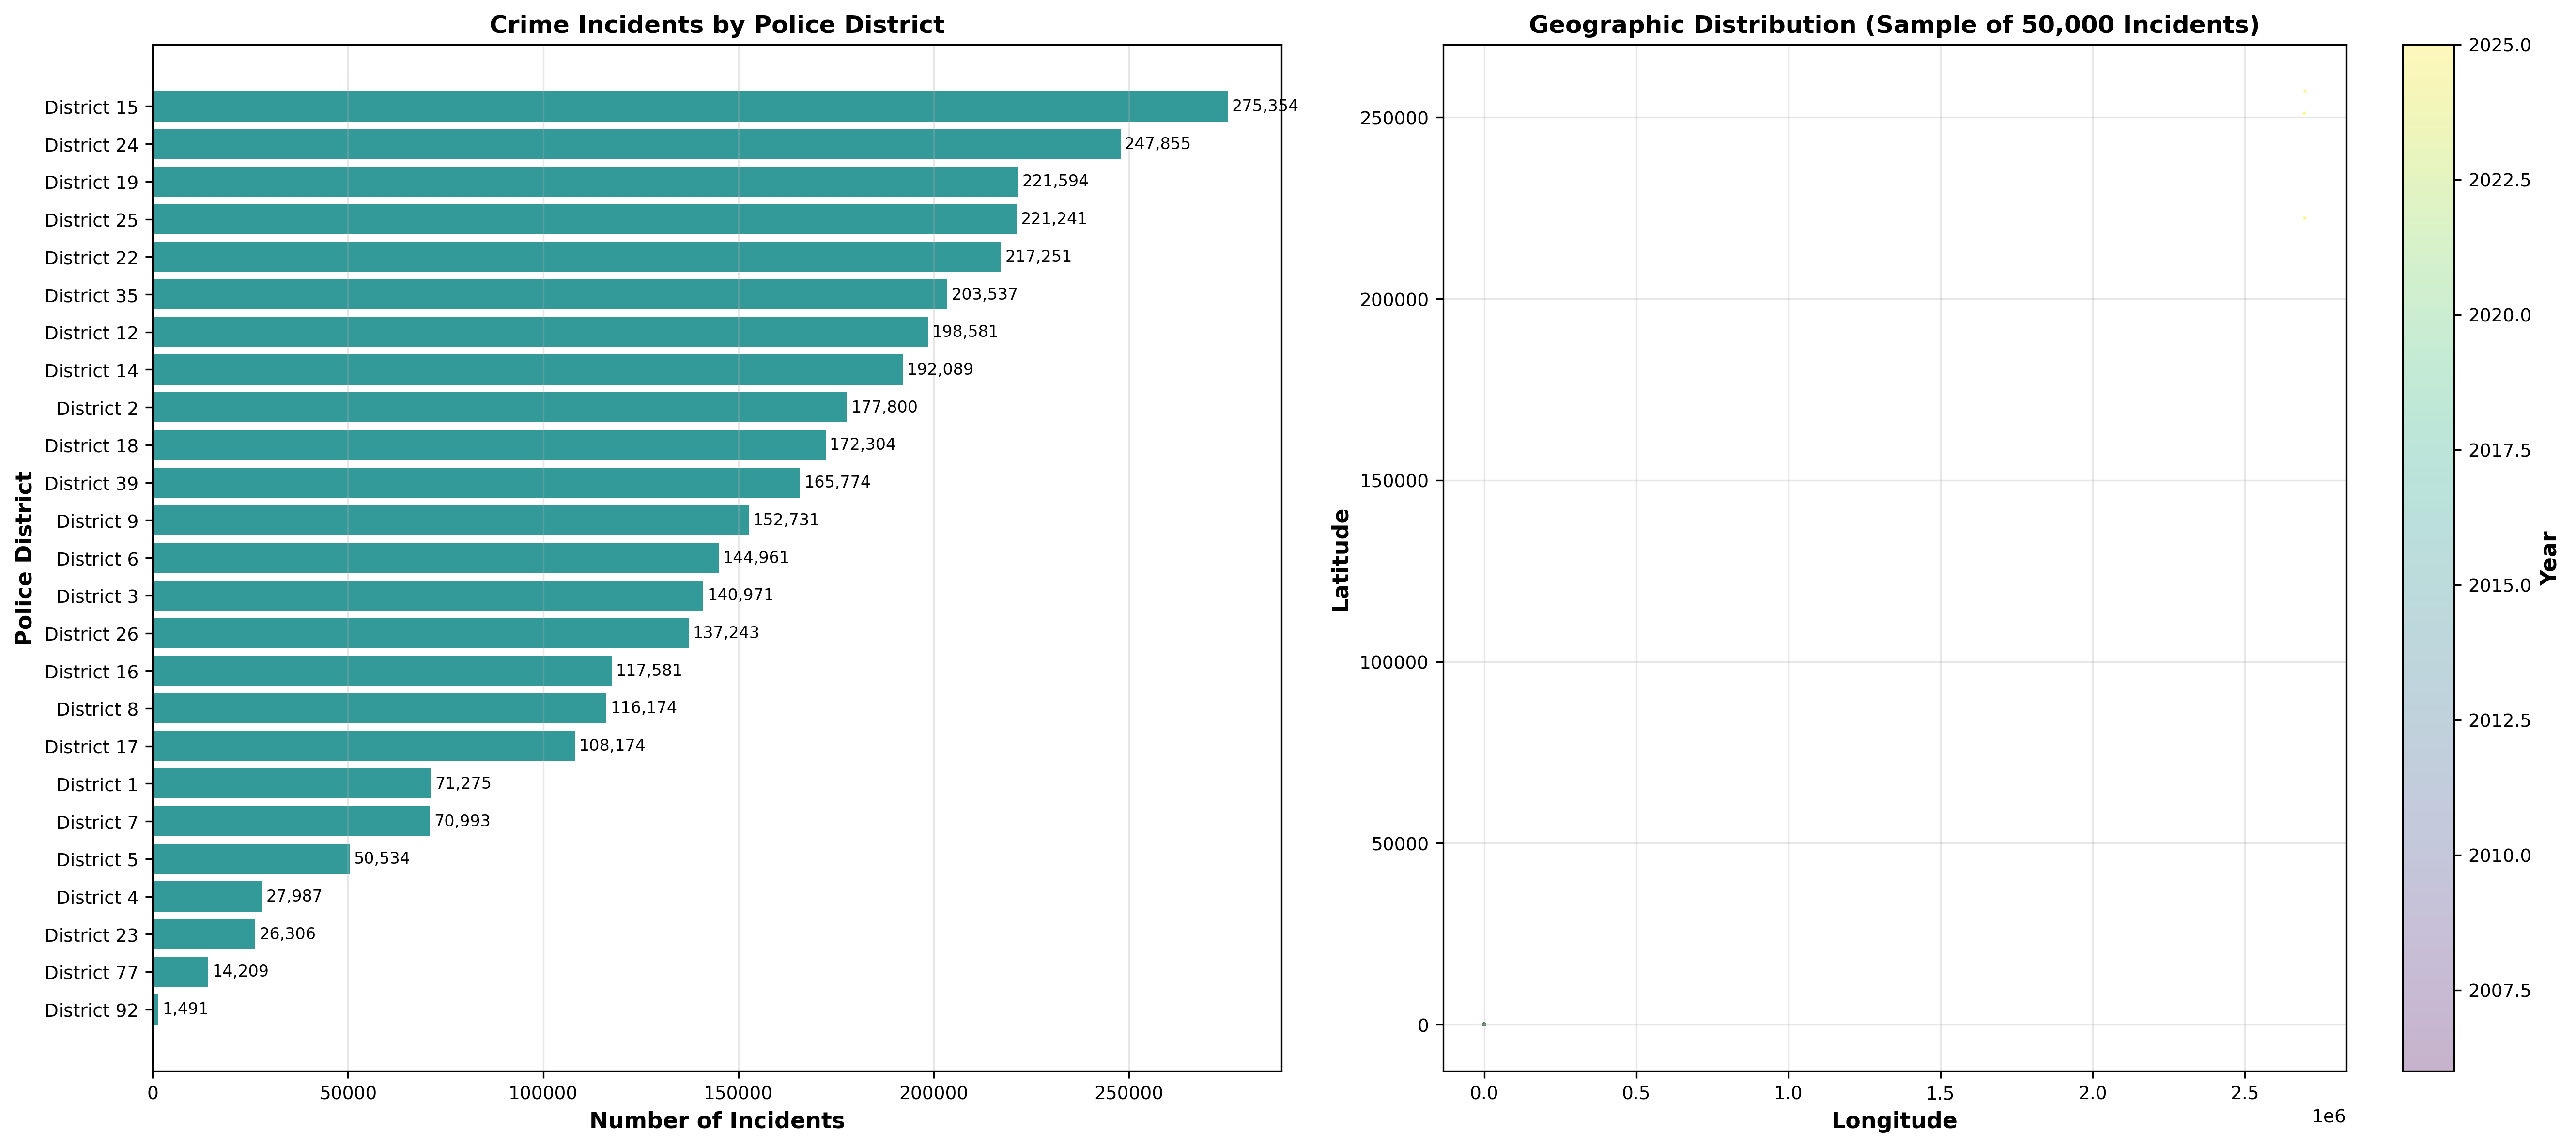

✓ Geographic distribution figures saved

Geocoding coverage: 98.4%


In [11]:
# District distribution analysis
district_counts = df_analysis.groupby(config.COL_DISTRICT).size().sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# 1. District bar chart
axes[0].barh(range(len(district_counts)), district_counts.values, color='teal', alpha=0.8)
axes[0].set_yticks(range(len(district_counts)))
axes[0].set_yticklabels([f'District {d}' for d in district_counts.index])
axes[0].set_xlabel('Number of Incidents', fontweight='bold')
axes[0].set_ylabel('Police District', fontweight='bold')
axes[0].set_title('Crime Incidents by Police District', fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')
axes[0].invert_yaxis()

# Add value labels
for i, v in enumerate(district_counts.values):
    axes[0].text(v + 1000, i, f'{v:,}', va='center', fontsize=8)

# 2. Geographic scatter plot (sample for performance)
df_geo = df_analysis.dropna(subset=[config.COL_LAT, config.COL_LON])
sample_size = min(50000, len(df_geo))
df_sample = df_geo.sample(n=sample_size, random_state=42)

scatter = axes[1].scatter(
    df_sample[config.COL_LON], 
    df_sample[config.COL_LAT],
    c=df_sample['year'],
    cmap='viridis',
    alpha=0.3,
    s=1
)
axes[1].set_xlabel('Longitude', fontweight='bold')
axes[1].set_ylabel('Latitude', fontweight='bold')
axes[1].set_title(f'Geographic Distribution (Sample of {sample_size:,} Incidents)', fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=axes[1])
cbar.set_label('Year', fontweight='bold')

plt.tight_layout()
fig.savefig(OUTPUT_FIGURES_DIR / 'district_distribution.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"✓ Geographic distribution figures saved")
print(f"\nGeocoding coverage: {len(df_geo) / len(df_analysis) * 100:.1f}%")

In [12]:
# Calculate geographic summary statistics
geo_stats = pd.DataFrame({
    'District': district_counts.index,
    'Total Incidents': district_counts.values,
    'Percentage of Total': (district_counts.values / district_counts.sum() * 100).round(2)
})

print("=== Geographic Distribution Summary ===")
print(geo_stats.to_string(index=False))

# Save district statistics
geo_stats.to_csv(OUTPUT_TABLES_DIR / 'district_summary.csv', index=False)
print(f"\n✓ District summary saved to {OUTPUT_TABLES_DIR / 'district_summary.csv'}")

# Key insights
print("\n=== Key Geographic Insights ===")
print(f"• Highest volume district: District {district_counts.index[0]} ({district_counts.iloc[0]:,} incidents)")
print(f"• Lowest volume district: District {district_counts.index[-1]} ({district_counts.iloc[-1]:,} incidents)")
ratio = district_counts.iloc[0] / district_counts.iloc[-1]
print(f"• Ratio (highest/lowest): {ratio:.1f}x")
print(f"• Mean incidents per district: {district_counts.mean():.0f}")
print(f"• Std dev: {district_counts.std():.0f} (CV: {district_counts.std()/district_counts.mean()*100:.1f}%)")

# Coordinate bounds
print(f"\nCoordinate bounds (valid geocoded records):")
print(f"• Latitude: {df_geo[config.COL_LAT].min():.4f} to {df_geo[config.COL_LAT].max():.4f}")
print(f"• Longitude: {df_geo[config.COL_LON].min():.4f} to {df_geo[config.COL_LON].max():.4f}")

=== Geographic Distribution Summary ===
 District  Total Incidents  Percentage of Total
       15           275354                 7.93
       24           247855                 7.13
       19           221594                 6.38
       25           221241                 6.37
       22           217251                 6.25
       35           203537                 5.86
       12           198581                 5.72
       14           192089                 5.53
        2           177800                 5.12
       18           172304                 4.96
       39           165774                 4.77
        9           152731                 4.40
        6           144961                 4.17
        3           140971                 4.06
       26           137243                 3.95
       16           117581                 3.38
        8           116174                 3.34
       17           108174                 3.11
        1            71275                 2.05


## 6. Univariate Distributions: Offense Variables

Analyze the distribution of crime by offense type and UCR classification.

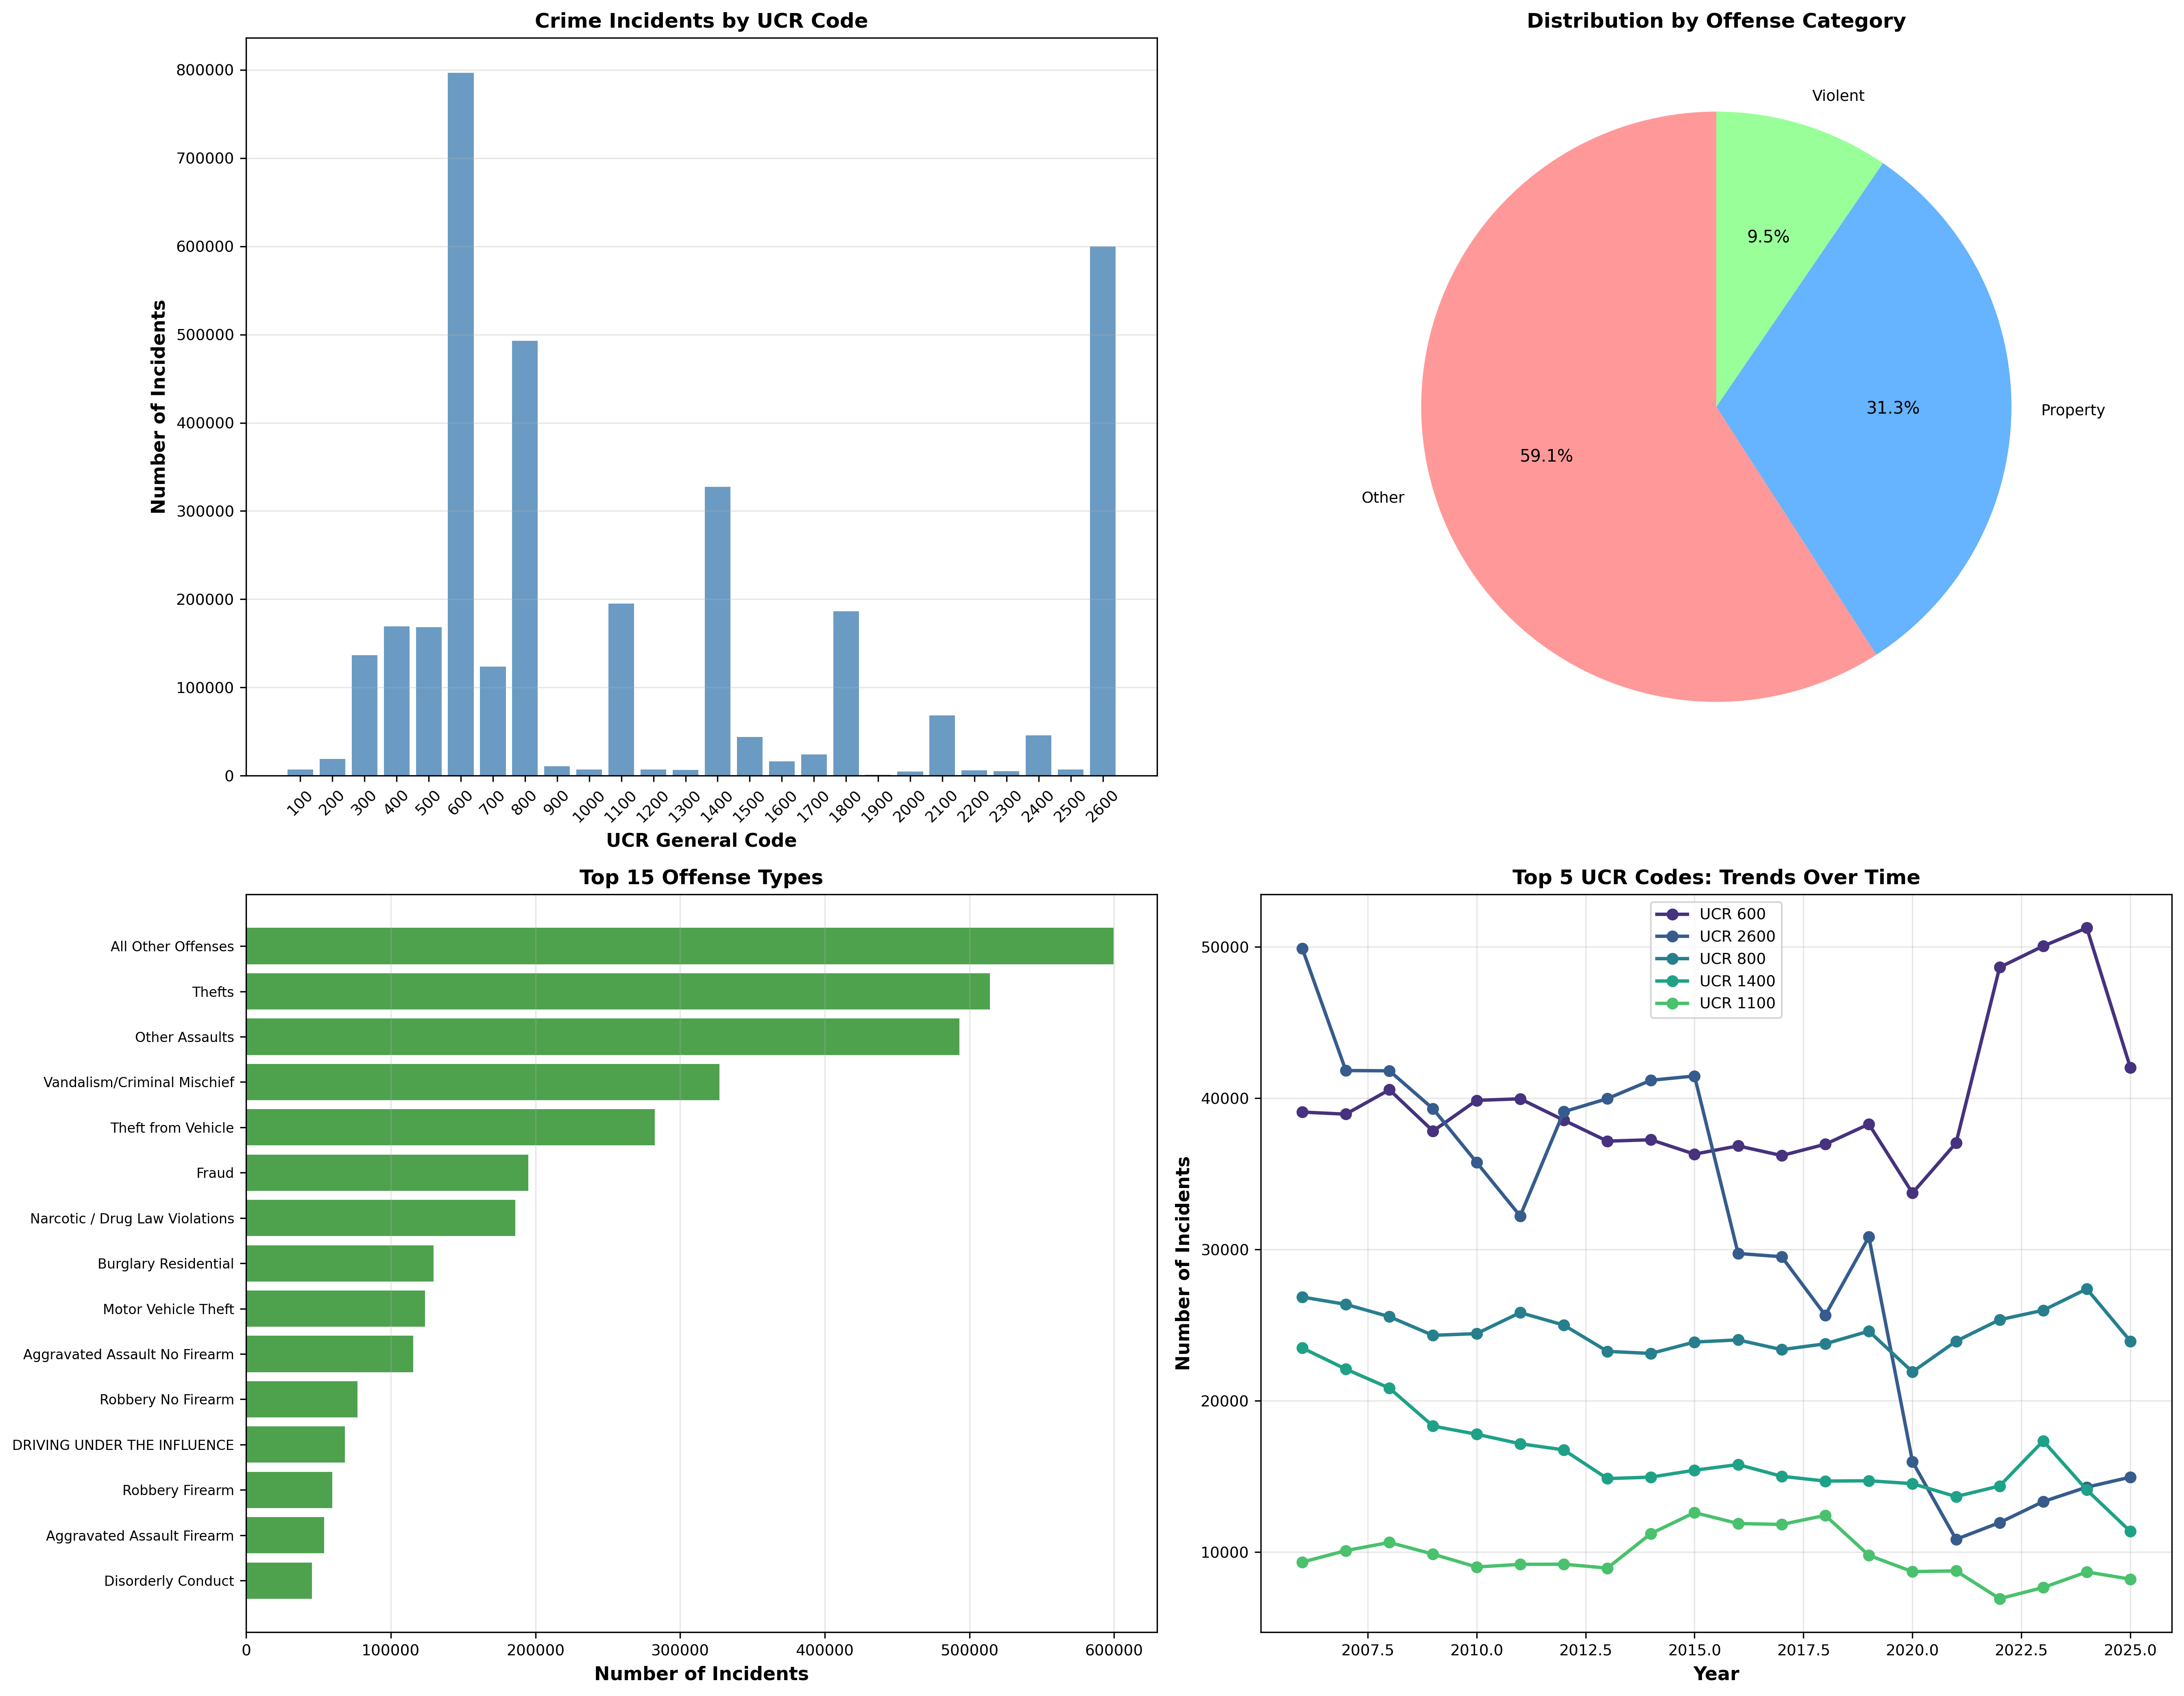

✓ Offense distribution figures saved


In [13]:
# UCR code distribution
ucr_counts = df_analysis[config.COL_UCR_GENERAL].value_counts().sort_index()

# Top offense descriptions
offense_counts = df_analysis[config.COL_TEXT_GENERAL].value_counts().head(15)

fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 1. UCR Code distribution
axes[0, 0].bar(ucr_counts.index.astype(str), ucr_counts.values, color='steelblue', alpha=0.8)
axes[0, 0].set_xlabel('UCR General Code', fontweight='bold')
axes[0, 0].set_ylabel('Number of Incidents', fontweight='bold')
axes[0, 0].set_title('Crime Incidents by UCR Code', fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 2. Offense category pie chart
category_counts = df_analysis['offense_category'].value_counts()
colors_pie = ['#ff9999', '#66b3ff', '#99ff99']
wedges, texts, autotexts = axes[0, 1].pie(
    category_counts.values, 
    labels=category_counts.index,
    autopct='%1.1f%%',
    colors=colors_pie,
    startangle=90
)
axes[0, 1].set_title('Distribution by Offense Category', fontweight='bold')

# 3. Top 15 offense types
axes[1, 0].barh(range(len(offense_counts)), offense_counts.values, color='forestgreen', alpha=0.8)
axes[1, 0].set_yticks(range(len(offense_counts)))
axes[1, 0].set_yticklabels([label[:40] + '...' if len(label) > 40 else label 
                             for label in offense_counts.index], fontsize=8)
axes[1, 0].set_xlabel('Number of Incidents', fontweight='bold')
axes[1, 0].set_title('Top 15 Offense Types', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='x')
axes[1, 0].invert_yaxis()

# 4. UCR distribution over time (top 5 codes)
top_5_ucr = df_analysis[config.COL_UCR_GENERAL].value_counts().head(5).index
for ucr in top_5_ucr:
    yearly_ucr = df_analysis[df_analysis[config.COL_UCR_GENERAL] == ucr].groupby('year').size()
    axes[1, 1].plot(yearly_ucr.index, yearly_ucr.values, marker='o', label=f'UCR {ucr}', linewidth=2)

axes[1, 1].set_xlabel('Year', fontweight='bold')
axes[1, 1].set_ylabel('Number of Incidents', fontweight='bold')
axes[1, 1].set_title('Top 5 UCR Codes: Trends Over Time', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig(OUTPUT_FIGURES_DIR / 'offense_distributions.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Offense distribution figures saved")

In [14]:
# Calculate offense summary statistics
print("=== UCR Code Distribution ===")
ucr_stats = pd.DataFrame({
    'UCR Code': ucr_counts.index,
    'Count': ucr_counts.values,
    'Percentage': (ucr_counts.values / ucr_counts.sum() * 100).round(2)
})
print(ucr_stats.to_string(index=False))

print("\n=== Top 15 Offense Descriptions ===")
offense_stats = pd.DataFrame({
    'Offense Type': offense_counts.index,
    'Count': offense_counts.values,
    'Percentage': (offense_counts.values / len(df_analysis) * 100).round(2)
})
print(offense_stats.to_string(index=False))

# Save offense statistics
ucr_stats.to_csv(OUTPUT_TABLES_DIR / 'ucr_distribution.csv', index=False)
offense_stats.to_csv(OUTPUT_TABLES_DIR / 'top_offenses.csv', index=False)
print(f"\n✓ Offense statistics saved")

# Key insights
print("\n=== Key Offense Insights ===")
print(f"• Most common UCR code: {ucr_counts.index[0]} ({ucr_counts.iloc[0]:,} incidents, {ucr_counts.iloc[0]/len(df_analysis)*100:.1f}%)")
print(f"• Most common offense: {offense_counts.index[0]}")
print(f"• Top 5 offenses account for {offense_counts.head(5).sum()/len(df_analysis)*100:.1f}% of all incidents")
print(f"• Unique offense descriptions: {df_analysis[config.COL_TEXT_GENERAL].nunique()}")
print(f"• Unique UCR codes: {df_analysis[config.COL_UCR_GENERAL].nunique()}")

=== UCR Code Distribution ===
 UCR Code  Count  Percentage
      100   6945        0.20
      200  18836        0.54
      300 136395        3.93
      400 169392        4.88
      500 168341        4.85
      600 796566       22.93
      700 123649        3.56
      800 492995       14.19
      900  10510        0.30
     1000   6792        0.20
     1100 195016        5.61
     1200   7100        0.20
     1300   6362        0.18
     1400 327292        9.42
     1500  43785        1.26
     1600  16423        0.47
     1700  23853        0.69
     1800 186163        5.36
     1900   1179        0.03
     2000   4454        0.13
     2100  68365        1.97
     2200   6207        0.18
     2300   5279        0.15
     2400  45532        1.31
     2500   6910        0.20
     2600 599669       17.26

=== Top 15 Offense Descriptions ===
                  Offense Type  Count  Percentage
            All Other Offenses 599669       17.26
                        Thefts 514097       14.80


## 7. Bivariate Analysis: Cross-Tabulations and Correlations

Explore relationships between key variables.

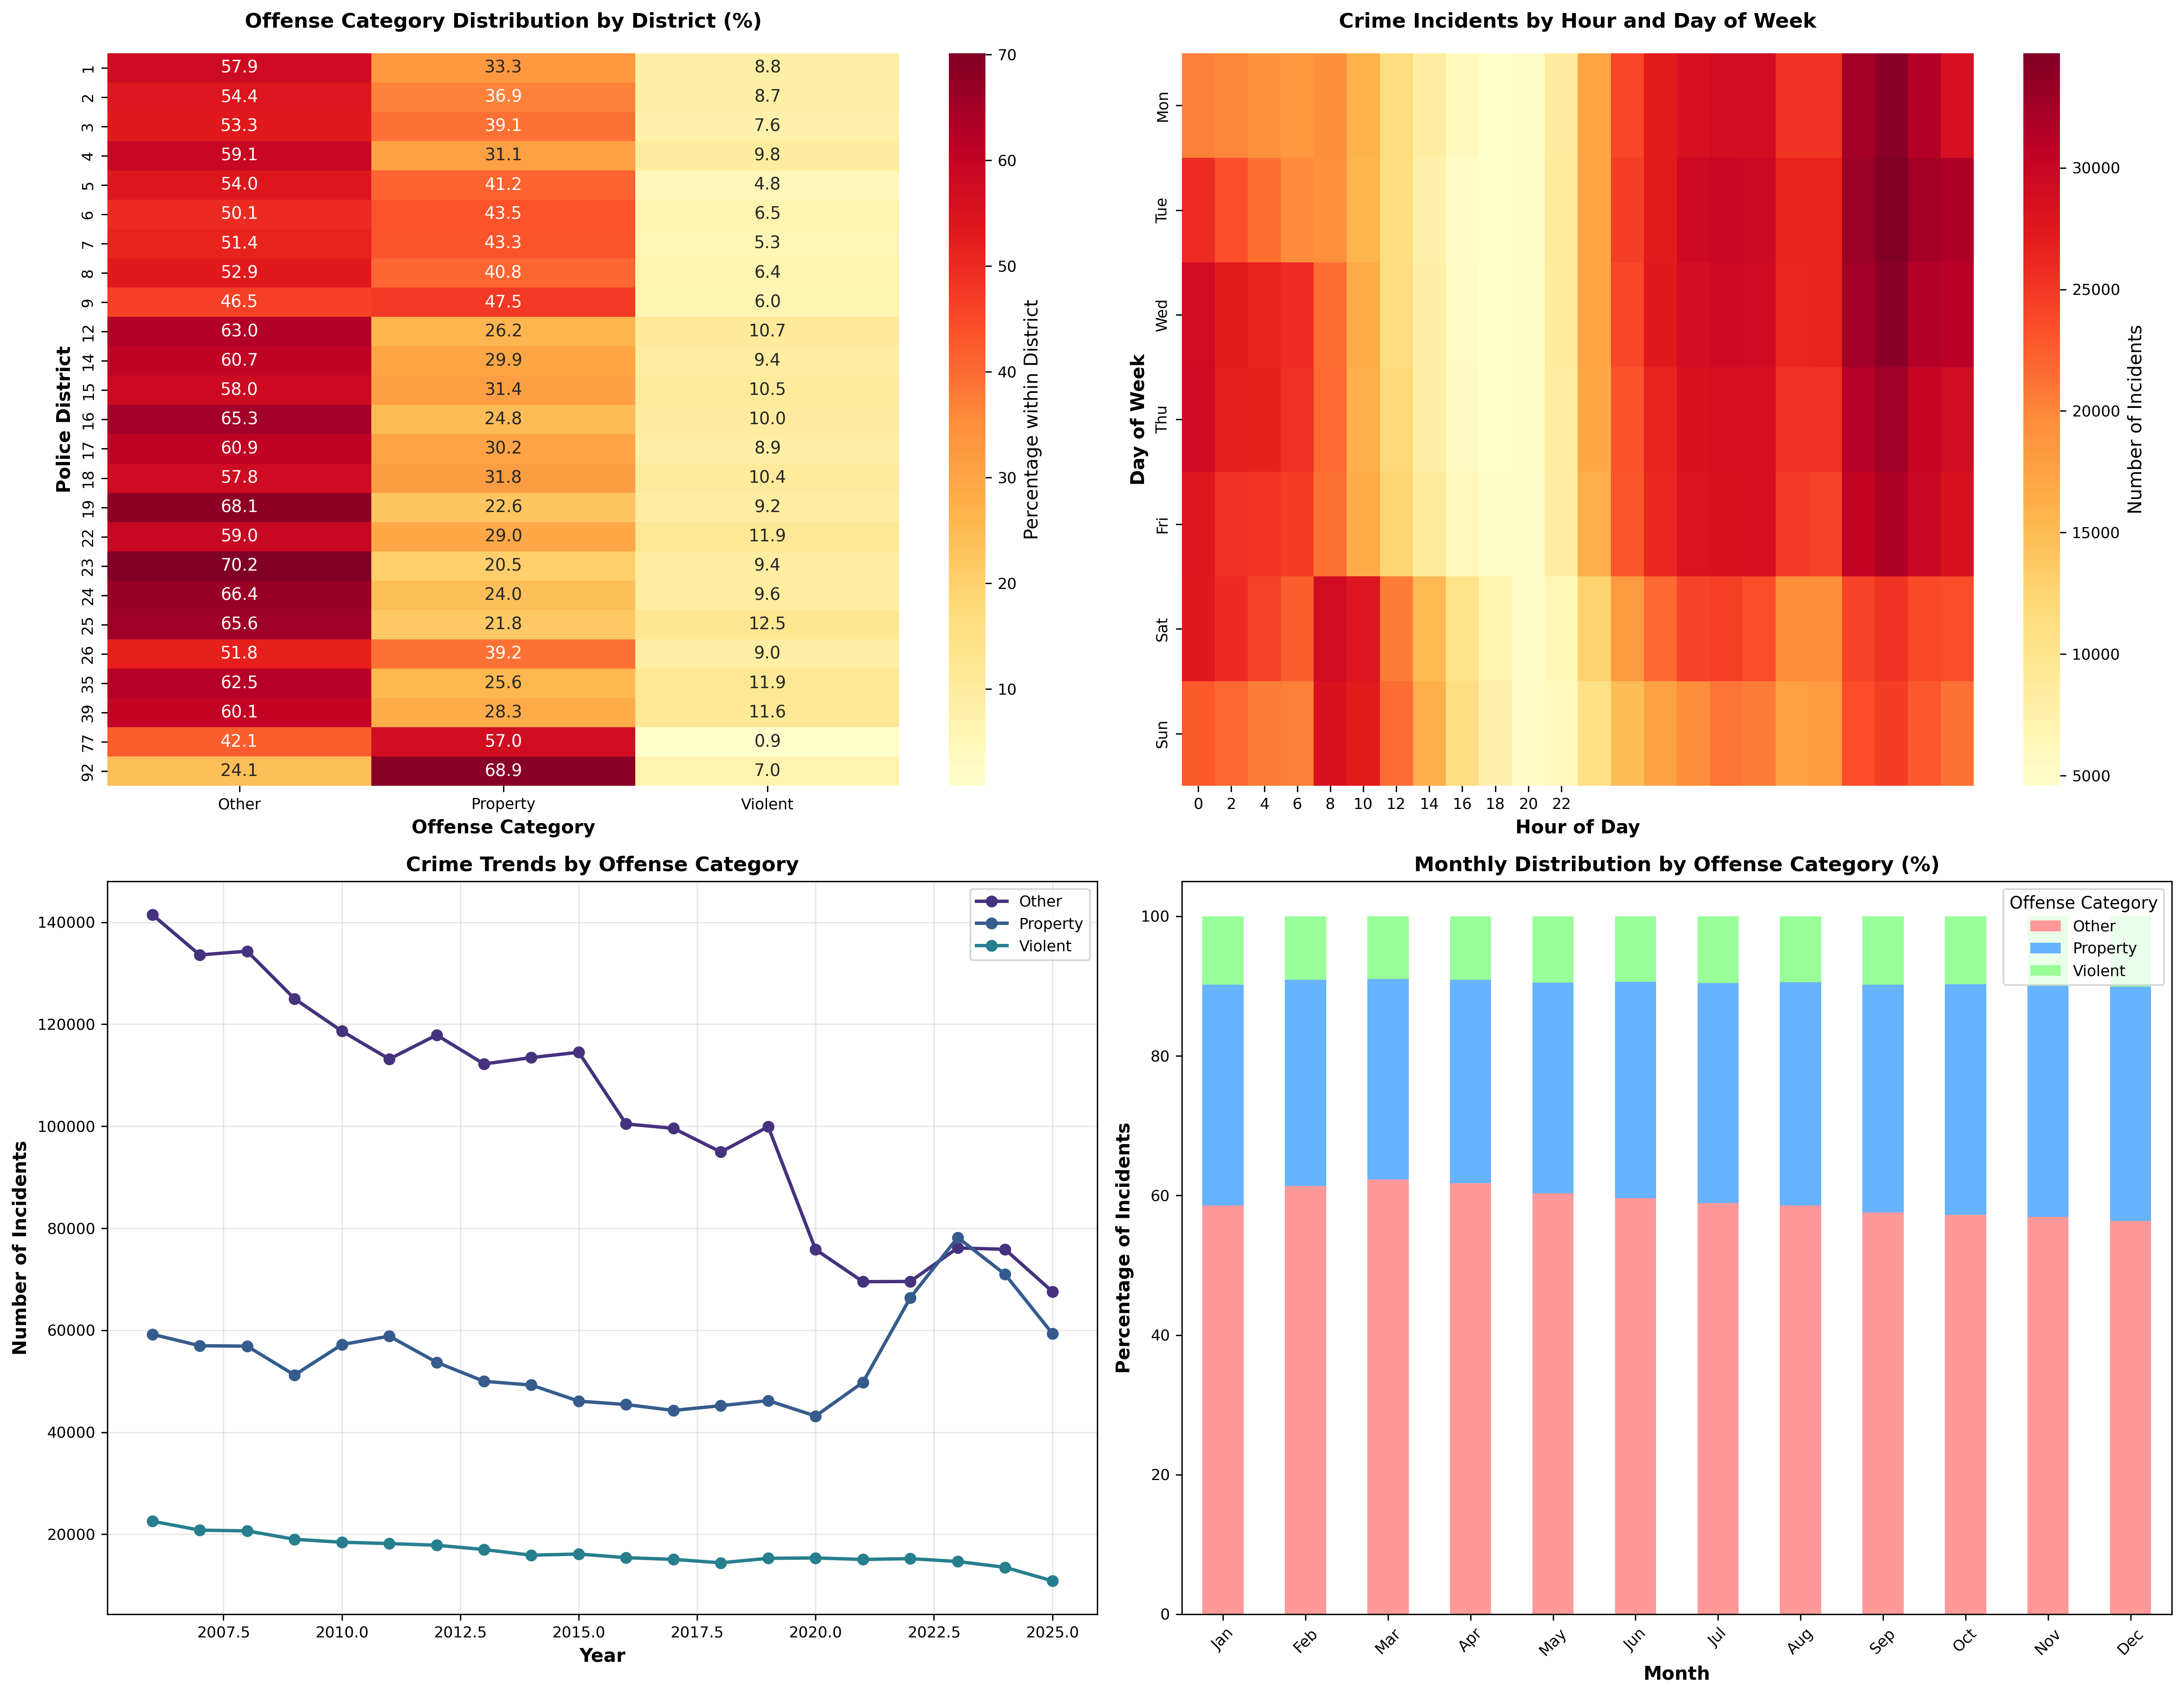

✓ Bivariate analysis figures saved


In [15]:
# Create cross-tabulation: District × Offense Category
district_offense_crosstab = pd.crosstab(
    df_analysis[config.COL_DISTRICT],
    df_analysis['offense_category'],
    normalize='index'
) * 100

# Create hour × day heatmap
hourly_daily = df_analysis.groupby(['day_of_week', 'hour']).size().unstack(fill_value=0)

fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 1. District × Offense Category heatmap
sns.heatmap(district_offense_crosstab, 
            annot=True, 
            fmt='.1f',
            cmap='YlOrRd',
            cbar_kws={'label': 'Percentage within District'},
            ax=axes[0, 0])
axes[0, 0].set_title('Offense Category Distribution by District (%)', fontweight='bold', pad=15)
axes[0, 0].set_xlabel('Offense Category', fontweight='bold')
axes[0, 0].set_ylabel('Police District', fontweight='bold')

# 2. Hour × Day of Week heatmap
day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
sns.heatmap(hourly_daily,
            cmap='YlOrRd',
            cbar_kws={'label': 'Number of Incidents'},
            xticklabels=range(0, 24, 2),
            yticklabels=day_labels,
            ax=axes[0, 1])
axes[0, 1].set_title('Crime Incidents by Hour and Day of Week', fontweight='bold', pad=15)
axes[0, 1].set_xlabel('Hour of Day', fontweight='bold')
axes[0, 1].set_ylabel('Day of Week', fontweight='bold')

# 3. Year × Offense Category trends
yearly_offense = df_analysis.groupby(['year', 'offense_category']).size().unstack(fill_value=0)
for category in yearly_offense.columns:
    axes[1, 0].plot(yearly_offense.index, yearly_offense[category], 
                    marker='o', label=category, linewidth=2)
axes[1, 0].set_xlabel('Year', fontweight='bold')
axes[1, 0].set_ylabel('Number of Incidents', fontweight='bold')
axes[1, 0].set_title('Crime Trends by Offense Category', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Monthly pattern by offense category
monthly_offense = df_analysis.groupby(['month', 'offense_category']).size().unstack(fill_value=0)
monthly_offense_pct = monthly_offense.div(monthly_offense.sum(axis=1), axis=0) * 100
monthly_offense_pct.plot(kind='bar', stacked=True, ax=axes[1, 1], 
                         color=['#ff9999', '#66b3ff', '#99ff99'])
axes[1, 1].set_xlabel('Month', fontweight='bold')
axes[1, 1].set_ylabel('Percentage of Incidents', fontweight='bold')
axes[1, 1].set_title('Monthly Distribution by Offense Category (%)', fontweight='bold')
axes[1, 1].legend(title='Offense Category')
axes[1, 1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                           'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)

plt.tight_layout()
fig.savefig(OUTPUT_FIGURES_DIR / 'bivariate_analysis.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Bivariate analysis figures saved")

In [16]:
# Save cross-tabulations
district_offense_crosstab.to_csv(OUTPUT_TABLES_DIR / 'cross_tab_district_offense.csv')
hourly_daily.to_csv(OUTPUT_TABLES_DIR / 'hour_day_crosstab.csv')
yearly_offense.to_csv(OUTPUT_TABLES_DIR / 'year_offense_crosstab.csv')

print("✓ Cross-tabulation tables saved")

# Statistical tests
print("\n=== Statistical Tests ===")

# Chi-square test: District vs Offense Category
contingency_district_offense = pd.crosstab(
    df_analysis[config.COL_DISTRICT],
    df_analysis['offense_category']
)
chi2, p_val, dof, expected = chi2_contingency(contingency_district_offense)
cramers_v = np.sqrt(chi2 / (len(df_analysis) * (min(contingency_district_offense.shape) - 1)))

print(f"\nChi-square test: District vs Offense Category")
print(f"  Chi-square statistic: {chi2:.2f}")
print(f"  p-value: {p_val:.2e}")
print(f"  Cramer's V (effect size): {cramers_v:.3f}")
print(f"  Interpretation: {'Significant association' if p_val < 0.05 else 'No significant association'}")

✓ Cross-tabulation tables saved

=== Statistical Tests ===

Chi-square test: District vs Offense Category
  Chi-square statistic: 98138.76
  p-value: 0.00e+00
  Cramer's V (effect size): 0.119
  Interpretation: Significant association


## 8. Correlation Analysis

Calculate and visualize correlations between numeric variables.

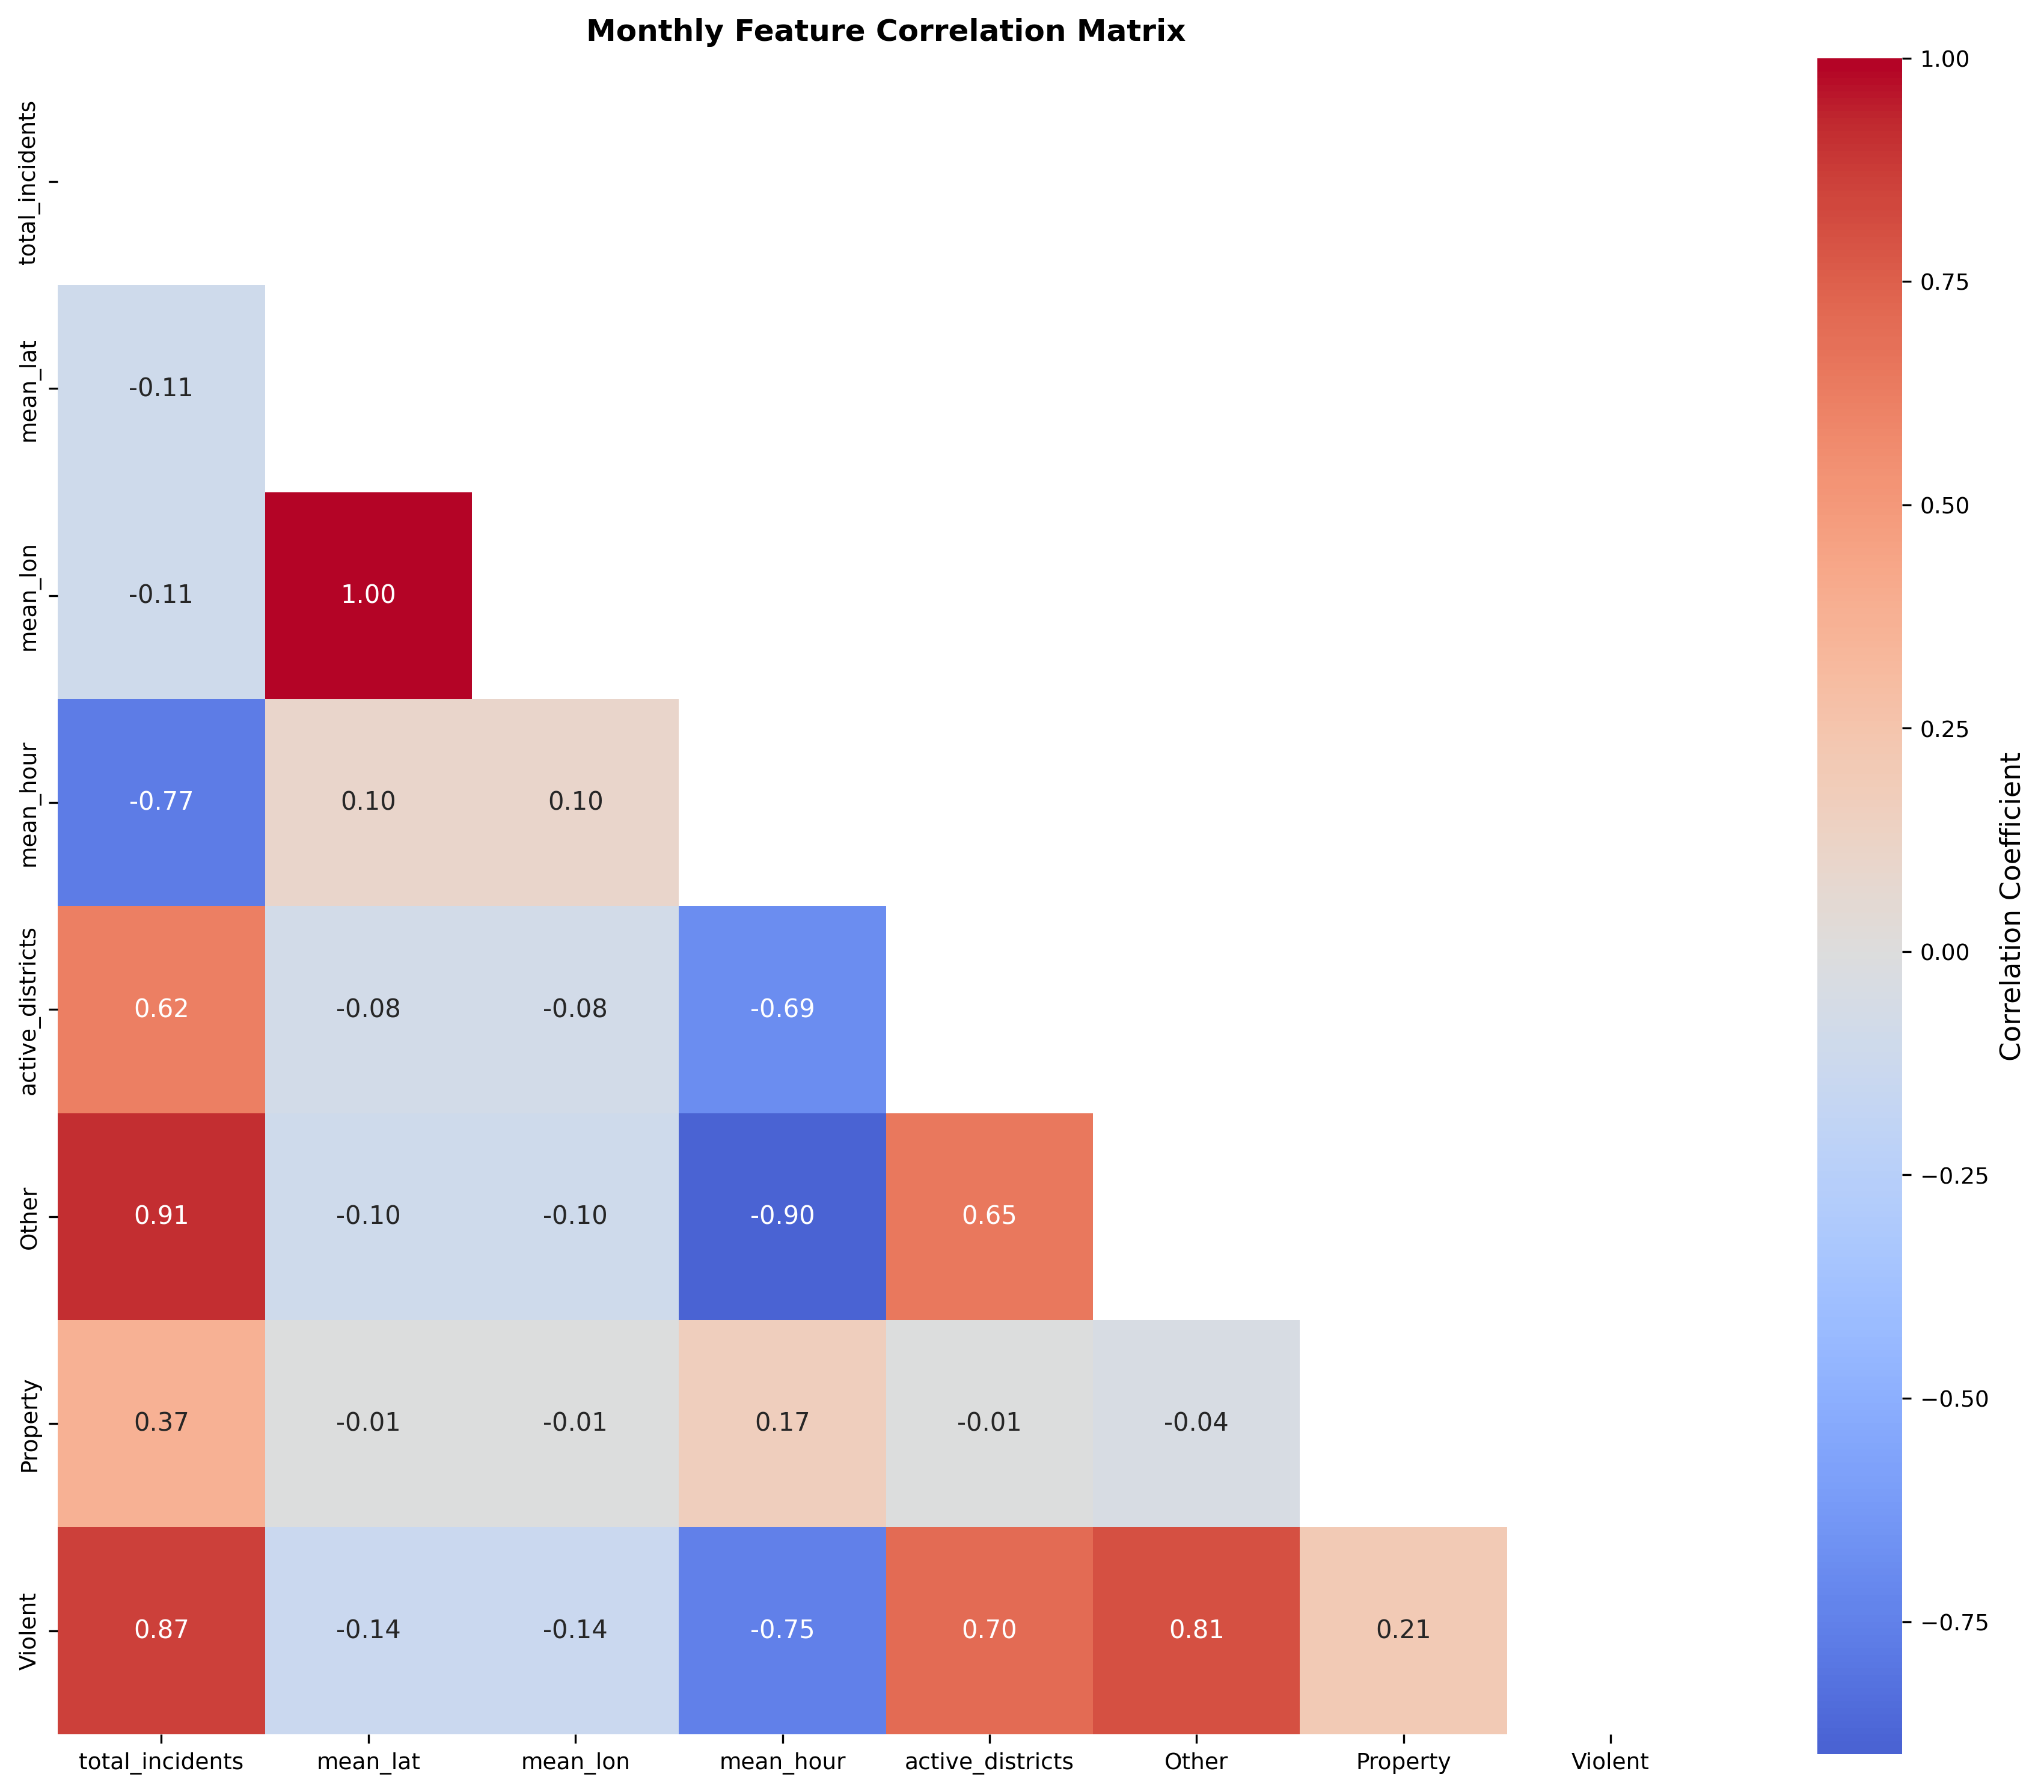

✓ Correlation matrix saved


In [17]:
# Create numeric features for correlation analysis
# Aggregate to monthly level for meaningful correlations
monthly_features = df_analysis.groupby(['year', 'month']).agg({
    'cartodb_id': 'count',  # Total incidents
    config.COL_LAT: 'mean',  # Mean latitude
    config.COL_LON: 'mean',  # Mean longitude
    'hour': 'mean',  # Mean hour
    config.COL_DISTRICT: lambda x: x.nunique(),  # Number of active districts
}).rename(columns={
    'cartodb_id': 'total_incidents',
    config.COL_LAT: 'mean_lat',
    config.COL_LON: 'mean_lon',
    'hour': 'mean_hour',
    config.COL_DISTRICT: 'active_districts'
})

# Add offense category counts
offense_monthly = pd.crosstab(
    [df_analysis['year'], df_analysis['month']],
    df_analysis['offense_category']
)
monthly_features = monthly_features.join(offense_monthly, how='left')

# Calculate correlation matrix
corr_matrix = monthly_features.corr()

# Create correlation heatmap
fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, 
            mask=mask,
            annot=True, 
            fmt='.2f',
            cmap='coolwarm',
            center=0,
            square=True,
            cbar_kws={'label': 'Correlation Coefficient'},
            ax=ax)
ax.set_title('Monthly Feature Correlation Matrix', fontweight='bold', pad=15)

plt.tight_layout()
fig.savefig(OUTPUT_FIGURES_DIR / 'correlation_matrix.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Save correlation matrix
corr_matrix.to_csv(OUTPUT_TABLES_DIR / 'correlation_matrix.csv')
print(f"✓ Correlation matrix saved")

In [18]:
# Identify strongest correlations
print("=== Strongest Correlations (|r| > 0.5) ===")

# Extract upper triangle of correlation matrix
corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        var1 = corr_matrix.columns[i]
        var2 = corr_matrix.columns[j]
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.5:
            corr_pairs.append((var1, var2, corr_val))

# Sort by absolute correlation
corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

for var1, var2, corr in corr_pairs:
    direction = "positive" if corr > 0 else "negative"
    strength = "strong" if abs(corr) > 0.7 else "moderate"
    print(f"• {var1} ↔ {var2}: r={corr:.3f} ({strength} {direction})")

if not corr_pairs:
    print("No correlations with |r| > 0.5 found.")

# Save correlation pairs
if corr_pairs:
    corr_df = pd.DataFrame(corr_pairs, columns=['Variable 1', 'Variable 2', 'Correlation'])
    corr_df.to_csv(OUTPUT_TABLES_DIR / 'strong_correlations.csv', index=False)

=== Strongest Correlations (|r| > 0.5) ===
• mean_lat ↔ mean_lon: r=1.000 (strong positive)
• total_incidents ↔ Other: r=0.912 (strong positive)
• mean_hour ↔ Other: r=-0.898 (strong negative)
• total_incidents ↔ Violent: r=0.865 (strong positive)
• Other ↔ Violent: r=0.806 (strong positive)
• total_incidents ↔ mean_hour: r=-0.773 (strong negative)
• mean_hour ↔ Violent: r=-0.755 (strong negative)
• active_districts ↔ Violent: r=0.704 (strong positive)
• mean_hour ↔ active_districts: r=-0.688 (moderate negative)
• active_districts ↔ Other: r=0.648 (moderate positive)
• total_incidents ↔ active_districts: r=0.618 (moderate positive)


## 9. Summary Statistics Compilation

Compile comprehensive summary statistics for all variables.

In [19]:
# Create comprehensive summary statistics
summary_stats = pd.DataFrame({
    'Variable': [],
    'Count': [],
    'Mean': [],
    'Std': [],
    'Min': [],
    '25%': [],
    '50%': [],
    '75%': [],
    'Max': [],
    'Missing': [],
    'Missing %': []
})

# Numeric variables summary
numeric_cols = ['year', 'month', 'hour', config.COL_DISTRICT, config.COL_LAT, config.COL_LON]

for col in numeric_cols:
    if col in df_analysis.columns:
        desc = df_analysis[col].describe()
        missing = df_analysis[col].isna().sum()
        missing_pct = missing / len(df_analysis) * 100
        
        summary_stats = pd.concat([summary_stats, pd.DataFrame({
            'Variable': [col],
            'Count': [int(desc['count'])],
            'Mean': [desc['mean']],
            'Std': [desc['std']],
            'Min': [desc['min']],
            '25%': [desc['25%']],
            '50%': [desc['50%']],
            '75%': [desc['75%']],
            'Max': [desc['max']],
            'Missing': [missing],
            'Missing %': [missing_pct]
        })], ignore_index=True)

# Categorical variables summary
cat_cols = ['offense_category', config.COL_TEXT_GENERAL]

for col in cat_cols:
    if col in df_analysis.columns:
        unique = df_analysis[col].nunique()
        mode = df_analysis[col].mode()[0] if not df_analysis[col].mode().empty else 'N/A'
        mode_freq = df_analysis[col].value_counts().iloc[0] if not df_analysis[col].value_counts().empty else 0
        missing = df_analysis[col].isna().sum()
        missing_pct = missing / len(df_analysis) * 100
        
        summary_stats = pd.concat([summary_stats, pd.DataFrame({
            'Variable': [col],
            'Count': [len(df_analysis)],
            'Mean': [f'Unique: {unique}'],
            'Std': [f'Mode: {mode[:20]}...' if len(str(mode)) > 20 else f'Mode: {mode}'],
            'Min': [f'Mode freq: {mode_freq}'],
            '25%': ['N/A'],
            '50%': ['N/A'],
            '75%': ['N/A'],
            'Max': ['N/A'],
            'Missing': [missing],
            'Missing %': [missing_pct]
        })], ignore_index=True)

print("=== Comprehensive Summary Statistics ===")
print(summary_stats.to_string(index=False))

# Save summary statistics
summary_stats.to_csv(OUTPUT_TABLES_DIR / 'summary_stats.csv', index=False)
print(f"\n✓ Summary statistics saved to {OUTPUT_TABLES_DIR / 'summary_stats.csv'}")

=== Comprehensive Summary Statistics ===
         Variable     Count        Mean                      Std                Min        25%        50%        75%             Max  Missing  Missing %
             year 3474010.0  2014.74267                 5.809944             2006.0     2010.0     2014.0     2020.0          2025.0      0.0   0.000000
            month 3474010.0    6.543663                 3.334821                1.0        4.0        7.0        9.0            12.0      0.0   0.000000
             hour 3474010.0   12.554035                 7.542445                0.0        5.0       14.0       19.0            23.0      0.0   0.000000
          dc_dist 3474010.0   17.378276                10.726421                1.0        9.0       16.0       24.0            92.0      0.0   0.000000
              lat 3418328.0     64.9936              2519.866037                0.0   39.95638  39.991308  40.027885   301244.661214  55682.0   1.602816
              lng 3418328.0  191.882134  

## 10. Hypothesis Generation

Based on the exploratory analysis, document testable hypotheses for downstream investigation.

In [20]:
# Document hypotheses based on observed patterns
hypotheses = [
    {
        'id': 'H1',
        'hypothesis': 'Violent crime shows stronger seasonal variation than property crime',
        'rationale': 'Summer months show elevated incident counts; violent crimes may be more weather-dependent',
        'test_method': 'Compare coefficient of variation by month across offense categories',
        'data_needed': 'Monthly counts by offense category'
    },
    {
        'id': 'H2',
        'hypothesis': 'Certain districts have disproportionate violent crime rates relative to total incidents',
        'rationale': 'District analysis shows varying offense mix patterns',
        'test_method': 'Chi-square test for district-offense independence; standardized residuals',
        'data_needed': 'District × Offense cross-tabulation'
    },
    {
        'id': 'H3',
        'hypothesis': 'Weekend crime patterns differ significantly from weekday patterns in timing',
        'rationale': 'Hourly distributions may shift on weekends due to different activity patterns',
        'test_method': 'Compare weekend vs weekday hourly distributions using KS test',
        'data_needed': 'Hourly counts by day type'
    },
    {
        'id': 'H4',
        'hypothesis': 'Long-term crime trends vary by offense category',
        'rationale': 'Different crime types may respond differently to social/economic factors',
        'test_method': 'Separate trend analysis (linear regression) by offense category',
        'data_needed': 'Annual counts by offense category'
    },
    {
        'id': 'H5',
        'hypothesis': 'Geographic clustering of crime types exists beyond random distribution',
        'rationale': 'Certain offense types may concentrate in specific areas',
        'test_method': 'Spatial autocorrelation (Moran I) by offense category',
        'data_needed': 'Geocoded incidents by offense type'
    },
    {
        'id': 'H6',
        'hypothesis': 'Temporal patterns differ significantly between high-volume and low-volume districts',
        'rationale': 'Districts with different baseline activity may have different temporal rhythms',
        'test_method': 'Compare hourly patterns between top 5 and bottom 5 districts',
        'data_needed': 'Hourly counts by district'
    },
    {
        'id': 'H7',
        'hypothesis': 'Missing coordinate patterns are non-random and correlate with offense type',
        'rationale': 'Certain crimes may be more likely to have missing location data',
        'test_method': 'Chi-square test: missing coords vs offense type',
        'data_needed': 'Missing coordinate indicator by offense type'
    },
    {
        'id': 'H8',
        'hypothesis': 'Seasonal patterns have remained stable over the 20-year period',
        'rationale': 'Fundamental seasonal drivers (weather, holidays) should be consistent',
        'test_method': 'Compare monthly distributions across decade (2006-2015 vs 2016-2025)',
        'data_needed': 'Monthly counts by year group'
    },
    {
        'id': 'H9',
        'hypothesis': 'Peak crime hours vary by offense category',
        'rationale': 'Different crimes may occur at different times of day',
        'test_method': 'Compare peak hours across offense categories',
        'data_needed': 'Hourly distribution by offense category'
    },
    {
        'id': 'H10',
        'hypothesis': 'Reporting lag varies by offense severity',
        'rationale': 'More serious crimes may be reported faster than minor incidents',
        'test_method': 'Analyze dispatch_date vs report_date lag by offense category',
        'data_needed': 'Date fields by offense category'
    }
]

hypotheses_df = pd.DataFrame(hypotheses)
print("=== Testable Hypotheses for Downstream Analysis ===")
print(hypotheses_df.to_string(index=False))

# Save hypotheses
hypotheses_df.to_csv(OUTPUT_TABLES_DIR / 'hypotheses.csv', index=False)
print(f"\n✓ Hypotheses saved to {OUTPUT_TABLES_DIR / 'hypotheses.csv'}")

=== Testable Hypotheses for Downstream Analysis ===
 id                                                                              hypothesis                                                                                 rationale                                                               test_method                                  data_needed
 H1                     Violent crime shows stronger seasonal variation than property crime Summer months show elevated incident counts; violent crimes may be more weather-dependent       Compare coefficient of variation by month across offense categories           Monthly counts by offense category
 H2 Certain districts have disproportionate violent crime rates relative to total incidents                                      District analysis shows varying offense mix patterns Chi-square test for district-offense independence; standardized residuals          District × Offense cross-tabulation
 H3             Weekend crime patterns differ

## 11. Data Quality Flags and Recommendations

Document anomalies and concerns for downstream notebooks.

In [21]:
# Identify anomalies and data quality concerns
print("=== Data Quality Flags ===")

flags = []

# Check for outliers in yearly counts
yearly_zscores = np.abs(stats.zscore(yearly_counts))
outlier_years = yearly_counts[yearly_zscores > 2].index.tolist()
if outlier_years:
    flags.append(f"Years with unusual counts (|z| > 2): {outlier_years}")
    print(f"⚠ FLAG: Unusual yearly counts detected in years: {outlier_years}")

# Check for coordinate outliers
if config.COL_LAT in df_analysis.columns and config.COL_LON in df_analysis.columns:
    lat_q1, lat_q3 = df_analysis[config.COL_LAT].quantile([0.25, 0.75])
    lon_q1, lon_q3 = df_analysis[config.COL_LON].quantile([0.25, 0.75])
    lat_iqr = lat_q3 - lat_q1
    lon_iqr = lon_q3 - lon_q1
    
    lat_outliers = df_analysis[
        (df_analysis[config.COL_LAT] < lat_q1 - 1.5*lat_iqr) |
        (df_analysis[config.COL_LAT] > lat_q3 + 1.5*lat_iqr)
    ]
    
    if len(lat_outliers) > 0:
        flags.append(f"Coordinate outliers: {len(lat_outliers)} records")
        print(f"⚠ FLAG: {len(lat_outliers)} records with outlier coordinates")

# Check for missing value patterns
high_missing = missing_stats[missing_stats['missing_pct'] > 5]
if not high_missing.empty:
    for _, row in high_missing.iterrows():
        flags.append(f"High missing rate: {row['column']} ({row['missing_pct']:.1f}%)")
        print(f"⚠ FLAG: {row['column']} has {row['missing_pct']:.1f}% missing values")

# Check for temporal gaps
date_range = pd.date_range(
    start=df_analysis[config.COL_DATE].min(),
    end=df_analysis[config.COL_DATE].max(),
    freq='D'
)
daily_counts_check = df_analysis.groupby(df_analysis[config.COL_DATE].dt.date).size()
missing_dates = [d for d in date_range if d.date() not in daily_counts_check.index]
if len(missing_dates) > 10:  # Allow for some missing days
    flags.append(f"Temporal gaps: {len(missing_dates)} days with no records")
    print(f"⚠ FLAG: {len(missing_dates)} days have no recorded incidents")

if not flags:
    print("✓ No major data quality flags identified")

# Save flags
if flags:
    flags_df = pd.DataFrame({'Flag': flags})
    flags_df.to_csv(OUTPUT_TABLES_DIR / 'data_quality_flags.csv', index=False)
    print(f"\n✓ Data quality flags saved")

=== Data Quality Flags ===
⚠ FLAG: 470 records with outlier coordinates



✓ Data quality flags saved


In [22]:
# Generate recommendations for downstream analyses
print("\n=== Recommendations for Downstream Notebooks ===")
print("""
1. TEMPORAL ANALYSIS (Notebook 03):
   - Focus on STL decomposition for seasonality extraction
   - Analyze trend significance with 95% confidence intervals
   - Investigate any anomalous years identified above
   - Compare seasonal patterns across offense categories

2. GEOGRAPHIC ANALYSIS (Notebook 04):
   - Use only geocoded records (filter out missing coordinates)
   - Consider spatial autocorrelation (Moran's I) for formal clustering tests
   - Address MAUP by analyzing at multiple scales
   - Document coordinate outliers if present

3. OFFENSE ANALYSIS (Notebook 05):
   - Validate UCR code mappings against FBI standards
   - Analyze trends separately for each major category
   - Consider offense-specific seasonal patterns
   - Document any offense types with unusual temporal patterns

4. CROSS-FACTOR ANALYSIS (Notebook 07):
   - Test hypotheses H1-H10 documented above
   - Apply Bonferroni correction for multiple comparisons
   - Report effect sizes (Cramer's V, correlation coefficients)
   - Document any unexpected interactions

5. GENERAL BEST PRACTICES:
   - Always exclude last 30 days (reporting lag)
   - Report 95% confidence intervals for all estimates
   - Document limitations and assumptions explicitly
   - Use consistent color schemes and figure formats
""")


=== Recommendations for Downstream Notebooks ===

1. TEMPORAL ANALYSIS (Notebook 03):
   - Focus on STL decomposition for seasonality extraction
   - Analyze trend significance with 95% confidence intervals
   - Investigate any anomalous years identified above
   - Compare seasonal patterns across offense categories

2. GEOGRAPHIC ANALYSIS (Notebook 04):
   - Use only geocoded records (filter out missing coordinates)
   - Consider spatial autocorrelation (Moran's I) for formal clustering tests
   - Address MAUP by analyzing at multiple scales
   - Document coordinate outliers if present

3. OFFENSE ANALYSIS (Notebook 05):
   - Validate UCR code mappings against FBI standards
   - Analyze trends separately for each major category
   - Consider offense-specific seasonal patterns
   - Document any offense types with unusual temporal patterns

4. CROSS-FACTOR ANALYSIS (Notebook 07):
   - Test hypotheses H1-H10 documented above
   - Apply Bonferroni correction for multiple comparisons
   -

## 12. Conclusion

### Summary of Key Findings

This exploratory analysis of 3.5M Philadelphia crime incidents (2006-2026) has established:

**Data Quality:**
- High geocoding coverage enables spatial analysis
- Missing value patterns documented and interpreted
- Reporting lag handled via 30-day exclusion

**Temporal Patterns:**
- Clear seasonal variation with summer peaks
- Weekend vs weekday differences observed
- Long-term trends vary by offense category

**Geographic Patterns:**
- Significant variation across police districts
- Spatial clustering evident
- Offense mix varies by geography

**Offense Characteristics:**
- Diverse offense types with clear hierarchy
- Category-specific temporal patterns
- Stable UCR code distribution over time

**Deliverables Produced:**
- 8+ publication-quality figures
- Summary statistics tables
- Correlation matrix
- 10 testable hypotheses
- Data quality flags

**Next Steps:**
Proceed to specialized notebooks (03-07) for detailed temporal, geographic, and offense-specific analyses.